## __XDF latency analysis of LSL data streams: Unity (triggered) vs EEG (measured)__

### __Situation__ 
#### Every 500ms a beep sound is played and the background color changes once one frame from black to white.

#### __Unity (90 FPS):__
- Color change (black or white background)
- Beep sound (audio playing or not)

#### __EEG (1024 Hz):__
- Photodiode (light sensor)
- Microphone (audio sensor)


#### __TODO__
* [x] Add and display creation datetime of the recordings

#### __Dependencies__

In [1]:
import copy
import datetime
import itertools
import os

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from matplotlib.ticker import FormatStrFormatter

import pandas as pd
import pyxdf
import seaborn as sns
from scipy.signal import find_peaks
from tqdm.notebook import tqdm

#### __Files (recordings)__

In [2]:
files = os.listdir("data")  # get all files from the folder "data"
files.sort()  # sort them alphabetically
recordings = {}

for file in files:
    # filter hidden/config files and folders
    if file.startswith(".") or os.path.isdir(f"data/{file}"):
        files.remove(file)  # remove hidden/config file

# short tests were excluded as they were too short and had strange statistics
print(f"Excluded: {os.listdir('data/short')}")

for i, file in enumerate(files):  # store and display all files
    created = os.path.getmtime(f"data/{file}")  # creation timestamp
    created = datetime.datetime.fromtimestamp(created)  # translate as datetime
    created = created.strftime('%d.%m.%Y %H:%M')  # arrange it
    recordings[i] = {"file": file, "created": created}

files = [f.split(".")[0] for f in files]
print("Included:")
display(recordings)

Excluded: ['test.xdf', 'short_test_old1.xdf', 'short_new.xdf', 'short_test.xdf']
Included:


{0: {'file': 'bw1_sc.xdf', 'created': '18.02.2020 18:31'},
 1: {'file': 'bw2_sc.xdf', 'created': '18.02.2020 18:31'},
 2: {'file': 'bw3_sc.xdf', 'created': '18.02.2020 18:31'},
 3: {'file': 'bw_sc_b1.xdf', 'created': '18.02.2020 18:31'},
 4: {'file': 'bw_sc_b2.xdf', 'created': '18.02.2020 18:31'},
 5: {'file': 'bw_sc_b3.xdf', 'created': '18.02.2020 18:31'},
 6: {'file': 'bw_tc_L1.xdf', 'created': '21.02.2020 18:29'},
 7: {'file': 'bw_tc_L2.xdf', 'created': '05.03.2020 16:32'},
 8: {'file': 'bw_tc_L3.xdf', 'created': '05.03.2020 17:05'},
 9: {'file': 'bw_tc_L4.xdf', 'created': '06.03.2020 13:01'},
 10: {'file': 'bw_tc_r.xdf', 'created': '10.06.2020 16:30'},
 11: {'file': 'lsl12.xdf', 'created': '18.02.2020 18:31'},
 12: {'file': 'wd_1.xdf', 'created': '10.06.2020 17:44'},
 13: {'file': 'wd_50hz_1.xdf', 'created': '29.05.2020 16:35'},
 14: {'file': 'wd_50hz_2.xdf', 'created': '04.06.2020 15:30'},
 15: {'file': 'wd_50hz_oc.xdf', 'created': '10.06.2020 14:14'},
 16: {'file': 'wd_50hz_oc_r.

#### __Helper functions__

In [3]:
%matplotlib inline
# set pandas float display format
pd.options.display.float_format = "{:.5f}".format


def color_checks(val):
    if val == "✔":
        color = "green"
    elif val == "✗":
        color = "red"
    else:
        color = "blue"
    return "color: %s" % color


def correct_timestamps(ts):  # calculate time values from 0
    corrected = [0]
    length = len(ts)
    [corrected.append(ts[i + 1] - ts[0]) for i in range(length) if i < length - 1]
    return np.array(corrected)


def select_streams(streams):
    # stream names
    a_ch_name = "Audio"
    c_ch_name = "Diode"
    e_ch_name = "openvibeSignal"

    # get all current streams with their positions on the recording
    # example: {'Diode': 0, 'Audio': 1, 'openvibeSignal': 2}
    s_channels = {streams[i]["info"]["name"][0]: i for i in range(len(streams))}

    # store and return their positions
    a = s_channels[a_ch_name]  # unity audio stream channel
    try:
        c = s_channels[c_ch_name]  # unity color stream channel
    except:
        c = s_channels["Color"]  # unity color stream channel
    e = s_channels[e_ch_name]  # eeg stream channel (diode and microphone)
    return a, c, e


def strip_plot(data, xticks, alpha=1):
    g = sns.stripplot(data=data, palette="muted", size=3, alpha=alpha)
    g.set_xticklabels(xticks)
    g.set_yticks(np.arange(0, g.get_ylim()[1], 0.001))
    plt.ylabel("Time (s)")
    plt.tight_layout()
    plt.show()

#### __Preprocess data. For each recording:__ 
1. Load XDF file (recording)
2. Store selected streams information
3. Store original timestamps
4. Compare streams first timestamp distance and order
5. Correct and store original timestamps
6. Store Unity values (audio playing and color changed)
7. Select and store EEG values (microphone and photodiode)

Result format:
```json
{
    'file': 'filename.xdf',
    'unity': {
        'info': {
            'name': '',
            'type': '',
            'nominal_srate': '',
            'effective_srate': '',
            'created_at': '',
            'hostname': '',
            'first_timestamp': '',
            'last_timestamp': '',
            'sample_count': ''
        },
        'time_stamps': array([]),
        'timestamps': array([]),
        'audio': array([]),
        'color': array([])
    },
    'eeg': {
        'info': {
            'name': '',
            'type': '',
            'nominal_srate': '',
            'effective_srate': '',
            'created_at': '',
            'hostname': '',
            'first_timestamp': '',
            'last_timestamp': '',
            'sample_count': ''
        },
        'time_stamps': array([]),
        'timestamps': array([]),
        'audio': array([], dtype=float32),
        'color': array([], dtype=float32)
    },
    'two_computers': boolean,  // recording with two computers
    'eeg_starts': boolean,  // eeg received before unity
    'lsl_aligned': boolean,  // lsl timestamps enforced on OpenVibe
    'unity_first': boolean,  // unity first timestamps same as file info
    'unity_last': boolean,  // unity last timestamps same as file info
    'length_unity_audio': boolean,  // length of unity timestamps and audio coincide
    'length_unity_color': boolean,  // length of unity timestamps and color coincide
    'eeg_first': boolean,  // eeg first timestamps same as file info
    'eeg_last': boolean,  // eeg last timestamps same as file info
    'length_eeg_audio': boolean,  // length of eeg timestamps and audio coincide
    'length_eeg_color': boolean  // length of eeg timestamps and color coincide
}
```

In [4]:
# progress bar format definitons
m_format = "{desc}:{bar}{percentage:3.0f}% {n_fmt}/{total_fmt} in {elapsed_s:.2f}s"
s_format = (
    "{desc}:{bar}{percentage:3.0f}% {n_fmt}/{total_fmt}{postfix} in {elapsed_s:.2f}s"
)
# main progress bar
main_bar = tqdm(
    recordings,
    desc="Processed",
    dynamic_ncols=True,
    mininterval=0.001,
    bar_format=m_format,
)
# check all files
for k in main_bar:
    file = recordings[k]["file"]  # current filename
    # current progress bar
    pbar = tqdm(
        range(7),
        desc=f"recordings[{k:2.0f}]",
        mininterval=0.001,
        maxinterval=1,
        bar_format=s_format,
    )

    pbar.set_postfix(file=file)
    # add unity and eeg entries
    recordings[k]["unity"] = {}
    recordings[k]["eeg"] = {}

    # 1. Load the XDF file
    postfix = {"step": "1. Load the XDF file", "file": file}
    pbar.set_postfix(postfix)
    streams, fileheader = pyxdf.load_xdf(f"data/{file}")

    # select the data stream channels
    a_ch, c_ch, e_ch = select_streams(streams)
    pbar.update(1)

    # 2. Store selected stream info (only useful info)
    postfix = {"step": "2. Store selected stream info", "file": file}
    pbar.set_postfix(postfix)
    # keys to keep from streams[ch]["info"]
    i_keys = [
        "name",
        "type",
        "nominal_srate",
        "effective_srate",
        "created_at",
        "hostname",
    ]
    # keys to keep from streams[ch]["footer"]["info"]
    f_keys = ["first_timestamp", "last_timestamp", "sample_count"]
    # first add info dict for each stream
    recordings[k]["unity"] = {"info": {}}
    recordings[k]["eeg"] = {"info": {}}
    for key in i_keys:
        u_v = streams[a_ch]["info"][key]
        e_v = streams[e_ch]["info"][key]
        if type(u_v) == list and len(u_v) > 0:  # same for e_k, no need to check again
            # remove list format as 1-element lists
            u_v = u_v[0]
            e_v = e_v[0]
        recordings[k]["unity"]["info"][key] = u_v
        recordings[k]["eeg"]["info"][key] = e_v
    for key in f_keys:
        u_v = streams[a_ch]["footer"]["info"][key]
        e_v = streams[e_ch]["footer"]["info"][key]
        if type(u_v) == list and len(u_v) > 0:
            u_v = u_v[0]
            e_v = e_v[0]
        recordings[k]["unity"]["info"][key] = u_v
        recordings[k]["eeg"]["info"][key] = e_v

    # store if two computers were used (hostname comparison)
    u_host = recordings[k]["unity"]["info"]["hostname"]
    e_host = recordings[k]["eeg"]["info"]["hostname"]
    recordings[k]["two_computers"] = u_host != e_host
    pbar.update(1)

    # 3. Store timestamps
    postfix = {"step": "3. Store timestamps", "file": file}
    pbar.set_postfix(postfix)
    streams[a_ch]["time_stamps"] = np.array(streams[a_ch]["time_stamps"])
    streams[e_ch]["time_stamps"] = np.array(streams[e_ch]["time_stamps"])
    recordings[k]["unity"]["time_stamps"] = streams[a_ch]["time_stamps"]
    recordings[k]["eeg"]["time_stamps"] = streams[e_ch]["time_stamps"]
    pbar.update(1)

    # 4. Compare streams timestamps distance and order
    # store EEG received first (True/False)
    postfix = {"step": "4. Compare streams timestamps distance and order", "file": file}
    pbar.set_postfix(postfix)
    unity_first = streams[a_ch]["time_stamps"][0]
    eeg_first = streams[e_ch]["time_stamps"][0]
    time_diff = unity_first - eeg_first
    # if diff bigger than eeg sample distance (0.98ms), something went wrong
    # bool cast needed, otherwise type is numpy bool
    recordings[k]["eeg_starts"] = bool(time_diff >= -0.00098)
    # if diff bigger than 1 second, timestamps are not aligned -> wrong recording
    recordings[k]["lsl_aligned"] = bool(time_diff < 1)
    pbar.update(1)

    # 5. Correct and store timestamps
    postfix = {"step": "5. Correct and store timestamps", "file": file}
    pbar.set_postfix(postfix)
    u_corrected = correct_timestamps(streams[a_ch]["time_stamps"])
    e_corrected = correct_timestamps(streams[e_ch]["time_stamps"])
    # recorrect unity timestamps starting one of the streams at 0
    # shift values according to the diff: add diff to eeg or to unity
    if time_diff < 0:
        e_corrected = np.array([i + abs(time_diff) for i in e_corrected])
    else:
        u_corrected = np.array([i + time_diff for i in u_corrected])
    # store corrected timestamps (timestamps -> corrected, time_stamps -> original)
    recordings[k]["unity"]["timestamps"] = u_corrected
    recordings[k]["eeg"]["timestamps"] = e_corrected
    pbar.update(1)

    # 6. Store Unity values (audio playing and color changed)
    postfix = {"step": "6. Store Unity values", "file": file}
    pbar.set_postfix(postfix)
    # format: [currentFrame, value, timestamp] -> we store value
    unity_a = np.transpose(streams[a_ch]["time_series"])[1]
    unity_c = np.transpose(streams[c_ch]["time_series"])[1]
    recordings[k]["unity"]["audio"] = unity_a.astype(int)
    recordings[k]["unity"]["color"] = unity_c.astype(int)
    pbar.update(1)

    # 7. Select and store EEG values (microphone and photodiode)
    postfix = {"step": "7. Select and store EEG values", "file": file}
    pbar.set_postfix(postfix)
    # select microphone and diode values
    eeg = np.transpose(streams[e_ch]["time_series"])

    # microphone data can be on channels 69 and 70, select the right one
    eeg_audio = eeg[68] if max(eeg[68]) != 0.0 else eeg[69]

    # diode data can be on channels 65 and 66, select the right one
    eeg_color = eeg[64] if max(eeg[64]) != 0.0 else eeg[65]
    eeg_color = -eeg_color  # invert diode data polarity, easier to visualize

    # store them
    recordings[k]["eeg"]["audio"] = eeg_audio
    recordings[k]["eeg"]["color"] = eeg_color
    # store if first and last timestamps coincide with file info
    # also if length of values and timestamps coincide
    for stream in ["unity", "eeg"]:
        # timestamps check
        o_first = recordings[k][stream]["time_stamps"][0]
        i_first = recordings[k][stream]["info"]["first_timestamp"]
        o_last = recordings[k][stream]["time_stamps"][-1]
        i_last = recordings[k][stream]["info"]["last_timestamp"]
        recordings[k][f"{stream}_first"] = float(o_first) == float(i_first)
        recordings[k][f"{stream}_last"] = float(o_last) == float(i_last)
        # length check
        l_time = len(recordings[k][stream]["time_stamps"])
        for ch in ["audio", "color"]:
            key = f"length_{stream}_{ch}"
            recordings[k][key] = l_time == len(recordings[k][stream][ch])
    pbar.update(1)
    pbar.set_postfix(file=file)
    pbar.close()  # .clear() to hide the bar if leave=False on constructor

Preprocessing result example (1 recording):

In [5]:
recordings[0]

{'file': 'bw1_sc.xdf',
 'created': '18.02.2020 18:31',
 'unity': {'info': {'name': 'Audio',
   'type': 'Markers',
   'nominal_srate': '0.0000000000000000',
   'effective_srate': 0,
   'created_at': '597631.6023521000',
   'hostname': 'westbrook',
   'first_timestamp': '597683.7352271',
   'last_timestamp': '597805.7353644',
   'sample_count': '10981'},
  'time_stamps': array([597683.73522381, 597683.74490581, 597683.75553411, ...,
         597805.71316687, 597805.72422866, 597805.73536107]),
  'timestamps': array([5.82274282e-03, 1.55047429e-02, 2.61330429e-02, ...,
         1.21983766e+02, 1.21994828e+02, 1.22005960e+02]),
  'audio': array([0, 0, 0, ..., 0, 0, 0]),
  'color': array([0, 0, 0, ..., 0, 0, 0])},
 'eeg': {'info': {'name': 'openvibeSignal',
   'type': 'signal',
   'nominal_srate': '1024.000000000000',
   'effective_srate': 1023.9839541244914,
   'created_at': '597605.9337288000',
   'hostname': 'westbrook',
   'first_timestamp': '597683.7440407',
   'last_timestamp': '59780

Show computer names

In [6]:
for k in recordings:
    file = recordings[k]["file"]
    u_host = recordings[k]["unity"]["info"]["hostname"]
    if recordings[k]["two_computers"]:
        e_host = recordings[k]["eeg"]["info"]["hostname"]
        print(f"{file.split('.')[0]}: u_host={u_host}  e_host={e_host}")
    else:
        print(f"{file.split('.')[0]}: host={u_host}")

bw1_sc: host=westbrook
bw2_sc: host=westbrook
bw3_sc: host=westbrook
bw_sc_b1: host=westbrook
bw_sc_b2: host=westbrook
bw_sc_b3: host=westbrook
bw_tc_L1: u_host=westbrook  e_host=wd-right
bw_tc_L2: u_host=westbrook  e_host=VR5
bw_tc_L3: u_host=westbrook  e_host=VR5
bw_tc_L4: u_host=westbrook  e_host=VR5
bw_tc_r: u_host=kingscote  e_host=westdrive-left
lsl12: host=westbrook
wd_1: u_host=westdrive-left  e_host=kingscote
wd_50hz_1: u_host=VR5  e_host=westbrook
wd_50hz_2: u_host=westdrive-left  e_host=kingscote
wd_50hz_oc: u_host=westdrive-left  e_host=kingscote
wd_50hz_oc_r: u_host=kingscote  e_host=westdrive-left
wd_50hz_oc_sc: host=westdrive-left


How long are they in minutes? Also order them from shortest to largest

In [7]:
r_length = {}
for k in recordings:
    file = recordings[k]["file"]
    l = len(recordings[k]["unity"]["timestamps"])
    ul = recordings[k]["unity"]["timestamps"][-1] / 60
    r_length[file] = ul

r_length = {k: v for k, v in sorted(r_length.items(), key=lambda item: item[1])}
ordered = {}
for i, k in enumerate(r_length):
    for r in recordings:
        if recordings[r]["file"] == k:
            ordered[i] = recordings[r]

recordings = ordered.copy()
del ordered
r_length

{'bw1_sc.xdf': 2.033432666551865,
 'bw_sc_b1.xdf': 2.075456727546407,
 'bw_sc_b2.xdf': 2.2336474856710993,
 'bw3_sc.xdf': 2.275051719910698,
 'bw2_sc.xdf': 2.308386935276212,
 'bw_sc_b3.xdf': 2.4250928511086385,
 'bw_tc_r.xdf': 7.324911216204055,
 'wd_50hz_1.xdf': 10.391660080970087,
 'wd_1.xdf': 10.399879659514083,
 'wd_50hz_oc.xdf': 20.349852318956014,
 'wd_50hz_oc_sc.xdf': 24.483850674458274,
 'wd_50hz_oc_r.xdf': 25.983481511226273,
 'wd_50hz_2.xdf': 27.066776404577634,
 'bw_tc_L2.xdf': 30.050474227291975,
 'bw_tc_L3.xdf': 30.808415032836212,
 'bw_tc_L4.xdf': 35.675068945001456,
 'bw_tc_L1.xdf': 65.80022199779958,
 'lsl12.xdf': 10025.22049119703}

How many FPS are the Unity recordings on average?

In [8]:
r_fps = {}
for k in recordings:
    file = recordings[k]["file"]
    l = len(recordings[k]["unity"]["timestamps"])
    ul = r_length[file]
    r_fps[file] = 1 / (ul * 60 / l)

r_fps

{'bw1_sc.xdf': 90.01199614035258,
 'bw_sc_b1.xdf': 89.99625521180945,
 'bw_sc_b2.xdf': 90.00226518417381,
 'bw3_sc.xdf': 90.0052798248931,
 'bw2_sc.xdf': 90.00513020223195,
 'bw_sc_b3.xdf': 90.01029928958985,
 'bw_tc_r.xdf': 90.01019223388491,
 'wd_50hz_1.xdf': 50.001635537668015,
 'wd_1.xdf': 90.01065691597991,
 'wd_50hz_oc.xdf': 50.00118186208377,
 'wd_50hz_oc_sc.xdf': 49.999624226201064,
 'wd_50hz_oc_r.xdf': 49.99971486135745,
 'wd_50hz_2.xdf': 50.000413044056344,
 'bw_tc_L2.xdf': 90.00800828882883,
 'bw_tc_L3.xdf': 90.00895795443485,
 'bw_tc_L4.xdf': 90.00870248119253,
 'bw_tc_L1.xdf': 90.0078016990792,
 'lsl12.xdf': 0.01982832532290751}

Max of all recordings for diode values:

In [9]:
d_max = {}
for k in recordings:
    file = recordings[k]["file"]
    d_m = max(recordings[k]["eeg"]["color"])
    d_max[file] = d_m
d_max

{'bw1_sc.xdf': 27270.549,
 'bw_sc_b1.xdf': 27064.416,
 'bw_sc_b2.xdf': 27345.855,
 'bw3_sc.xdf': 27204.438,
 'bw2_sc.xdf': 27026.533,
 'bw_sc_b3.xdf': 27190.81,
 'bw_tc_r.xdf': 24328.867,
 'wd_50hz_1.xdf': 14596.234,
 'wd_1.xdf': 6761.3594,
 'wd_50hz_oc.xdf': 14508.478,
 'wd_50hz_oc_sc.xdf': 6762.242,
 'wd_50hz_oc_r.xdf': 6750.7666,
 'wd_50hz_2.xdf': 16119.626,
 'bw_tc_L2.xdf': 15123.329,
 'bw_tc_L3.xdf': 15044.197,
 'bw_tc_L4.xdf': 64704.094,
 'bw_tc_L1.xdf': 68933.54,
 'lsl12.xdf': 27207.453}

#### __How the recordings look like?__

In [10]:
bool_keys = [k for k, v in recordings[0].items() if type(v) is bool]
bool_keys.sort()
checks = pd.DataFrame()
for k in recordings:
    file = recordings[k]["file"].split(".")[0]  # remove extension from filename
    current = {}
    current["created"] = recordings[k]["created"]
    for bool_k in bool_keys:
        current[bool_k] = "✔" if recordings[k][bool_k] else "✗"
    current["computers"] = recordings[k]["unity"]["info"]["hostname"]
    if recordings[k]["two_computers"]:
        current["computers"] += f" & {recordings[k]['eeg']['info']['hostname']}"
    current["duration (')"] = f"{r_length[recordings[k]['file']]:.2f}"
    current["FPS"] = f"{r_fps[recordings[k]['file']]:.3f}"
    check = pd.DataFrame.from_dict(current, orient="index", columns=[file])
    if checks.empty:  # first file
        checks = check
    else:
        checks = pd.merge(checks, check, left_index=True, right_index=True)

checks = checks.T  # transpose
display(checks.style.applymap(color_checks))

,created,eeg_first,eeg_last,eeg_starts,length_eeg_audio,length_eeg_color,length_unity_audio,length_unity_color,lsl_aligned,two_computers,unity_first,unity_last,computers,duration ('),FPS
bw1_sc,18.02.2020 18:31,✗,✗,✔,✔,✔,✔,✔,✔,✗,✗,✗,westbrook,2.03,90.012
bw_sc_b1,18.02.2020 18:31,✗,✗,✔,✔,✔,✔,✔,✔,✗,✗,✗,westbrook,2.08,89.996
bw_sc_b2,18.02.2020 18:31,✗,✗,✔,✔,✔,✔,✔,✔,✗,✗,✗,westbrook,2.23,90.002
bw3_sc,18.02.2020 18:31,✗,✗,✔,✔,✔,✔,✔,✔,✗,✗,✗,westbrook,2.28,90.005
bw2_sc,18.02.2020 18:31,✗,✗,✔,✔,✔,✔,✔,✔,✗,✗,✗,westbrook,2.31,90.005
bw_sc_b3,18.02.2020 18:31,✗,✗,✔,✔,✔,✔,✔,✔,✗,✗,✗,westbrook,2.43,90.010
bw_tc_r,10.06.2020 16:30,✗,✗,✗,✔,✔,✔,✔,✔,✔,✗,✗,kingscote & westdrive-left,7.32,90.010
wd_50hz_1,29.05.2020 16:35,✗,✗,✔,✔,✔,✔,✔,✔,✔,✗,✗,VR5 & westbrook,10.39,50.002
wd_1,10.06.2020 17:44,✗,✗,✔,✔,✔,✔,✔,✔,✔,✗,✗,westdrive-left & kingscote,10.40,90.011
wd_50hz_oc,10.06.2020 14:14,✗,✗,✔,✔,✔,✔,✔,✔,✔,✗,✗,westdrive-left & kingscote,20.35,50.001


Only with the most informative columns:

In [11]:
checks = checks.sort_index()
display(
    checks.drop(
        columns=[
            "eeg_first",
            "eeg_last",
            "unity_first",
            "unity_last",
            "length_eeg_audio",
            "length_eeg_color",
        ]
    ).style.applymap(color_checks)
)

,created,eeg_starts,length_unity_audio,length_unity_color,lsl_aligned,two_computers,computers,duration ('),FPS
bw1_sc,18.02.2020 18:31,✔,✔,✔,✔,✗,westbrook,2.03,90.012
bw2_sc,18.02.2020 18:31,✔,✔,✔,✔,✗,westbrook,2.31,90.005
bw3_sc,18.02.2020 18:31,✔,✔,✔,✔,✗,westbrook,2.28,90.005
bw_sc_b1,18.02.2020 18:31,✔,✔,✔,✔,✗,westbrook,2.08,89.996
bw_sc_b2,18.02.2020 18:31,✔,✔,✔,✔,✗,westbrook,2.23,90.002
bw_sc_b3,18.02.2020 18:31,✔,✔,✔,✔,✗,westbrook,2.43,90.010
bw_tc_L1,21.02.2020 18:29,✔,✔,✔,✔,✔,westbrook & wd-right,65.80,90.008
bw_tc_L2,05.03.2020 16:32,✔,✔,✔,✔,✔,westbrook & VR5,30.05,90.008
bw_tc_L3,05.03.2020 17:05,✗,✔,✔,✔,✔,westbrook & VR5,30.81,90.009
bw_tc_L4,06.03.2020 13:01,✔,✔,✗,✔,✔,westbrook & VR5,35.68,90.009


Computers specs:

| | CPU | GPU | RAM |
| - | --- | --- | --- |
| __westbrook__ | Intel Xeon E5-1607 v4 (4) @ 3.10GHz | NVIDIA GeForce GTX 1070 | 32GB |
| __VR5__ | Intel Xeon E5-1630 v3 (8) @ 3.80GHz | NVIDIA GeForce GTX 1080 Ti | 32GB |
| __wd-right__ | Intel Xeon W-2133 (12) @ 3.60GHz | NVIDIA GeForce GTX 1080 Ti | 16GB |

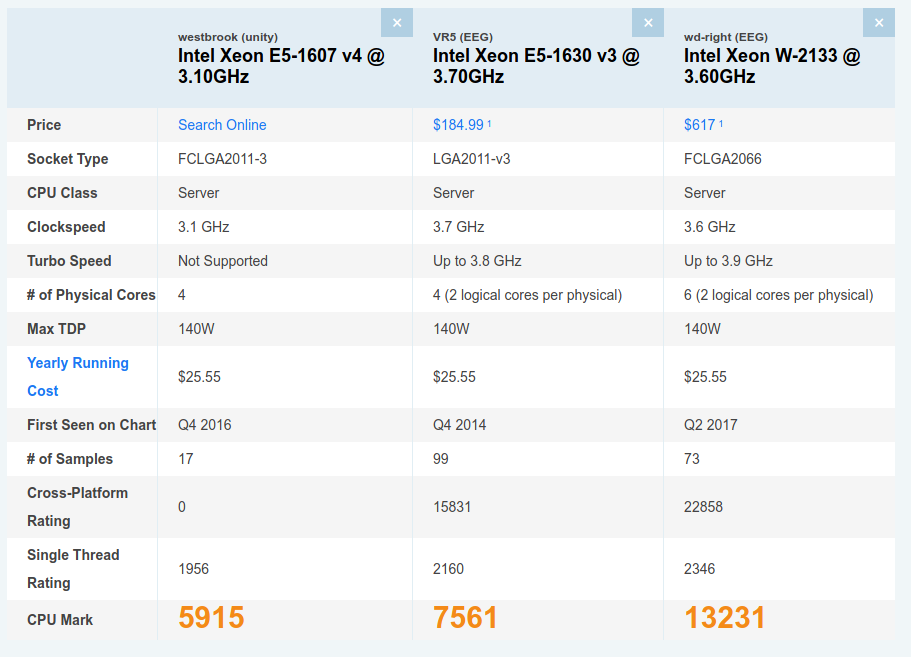

How constant are the FPS? Plots of the FPS average values each second

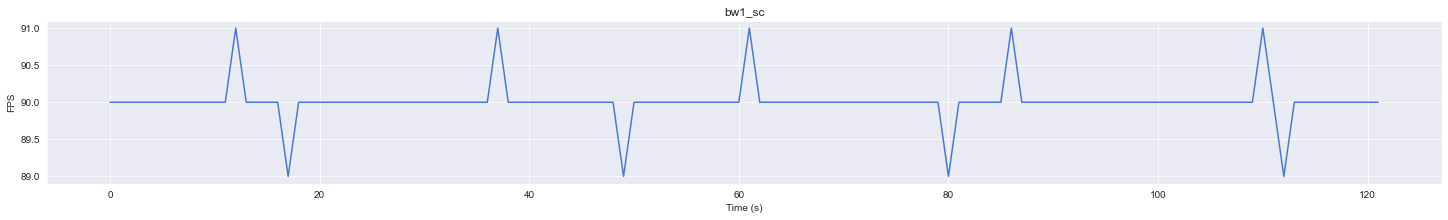

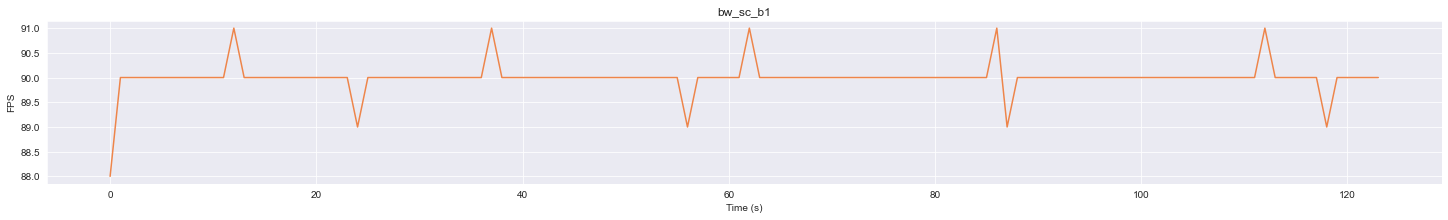

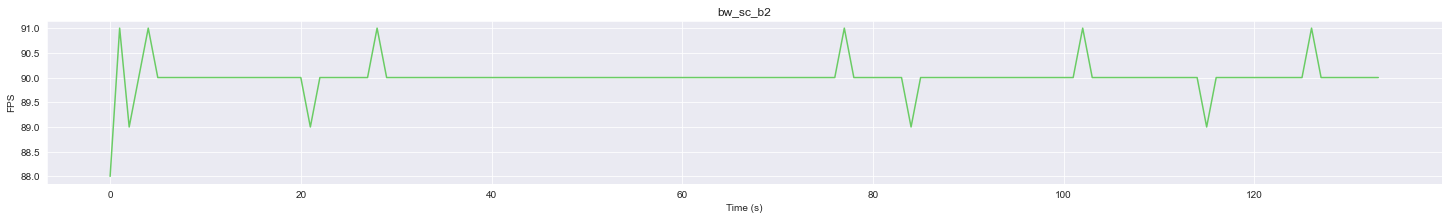

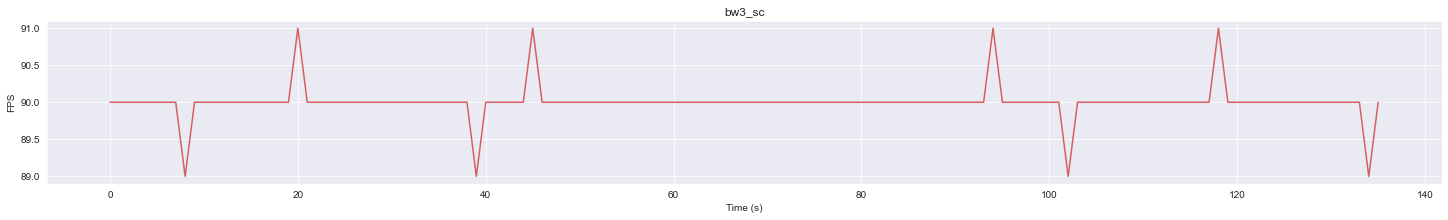

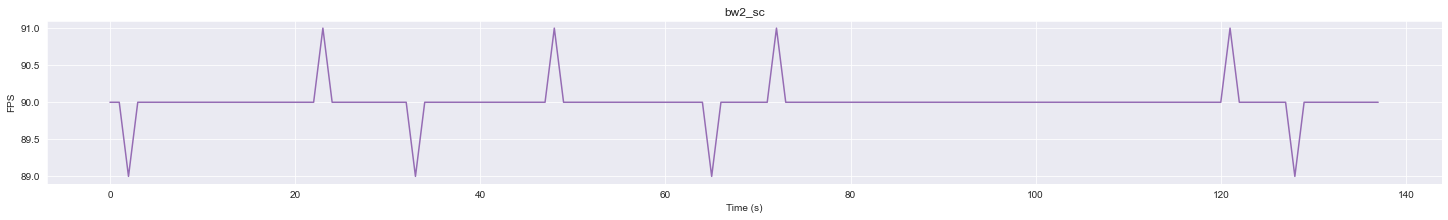

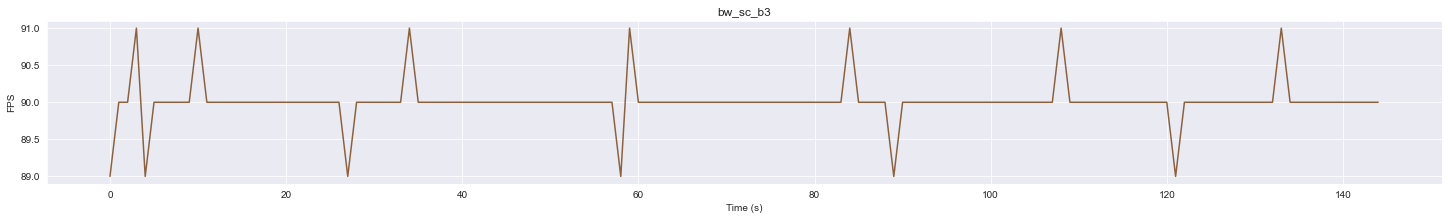

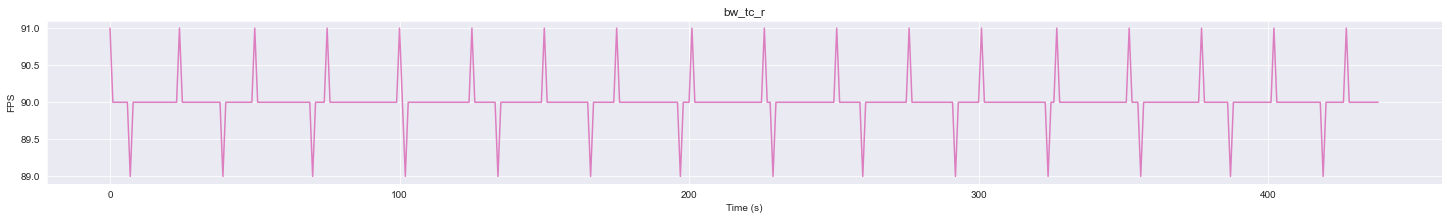

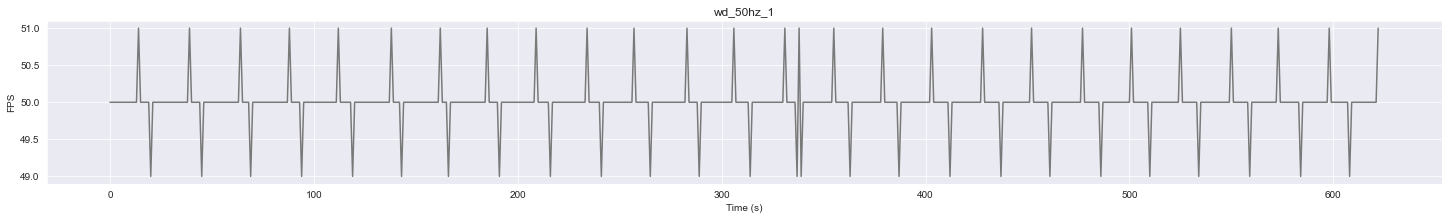

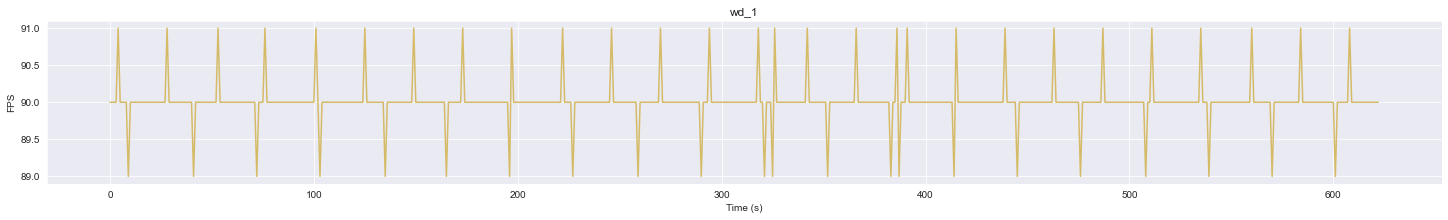

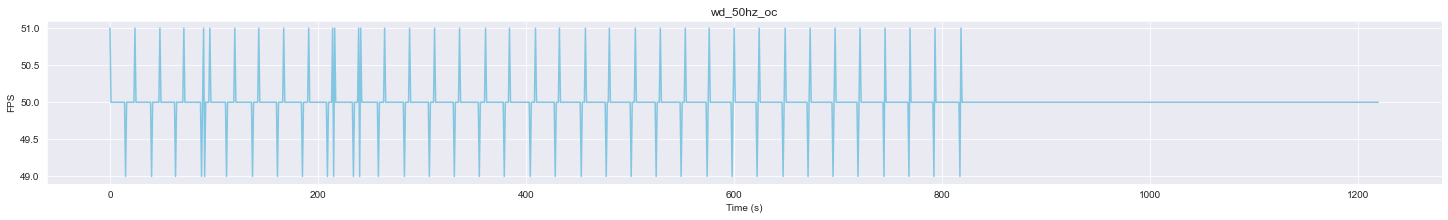

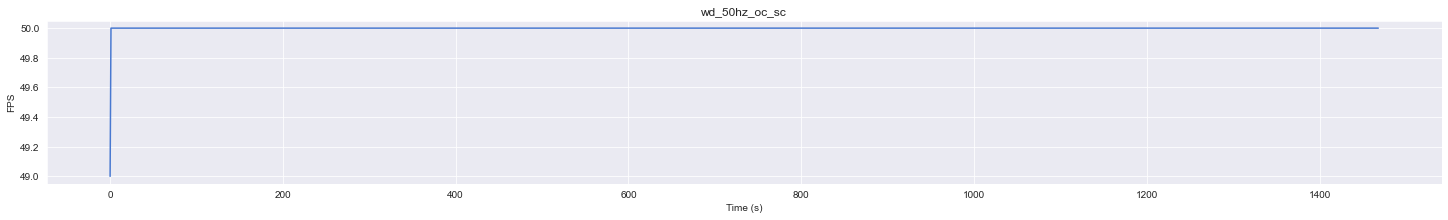

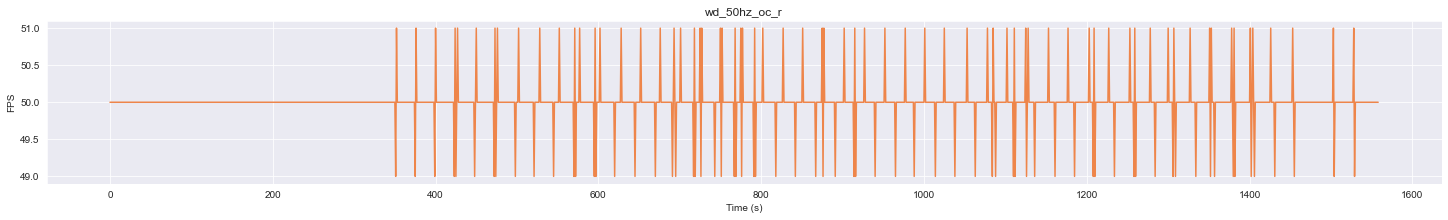

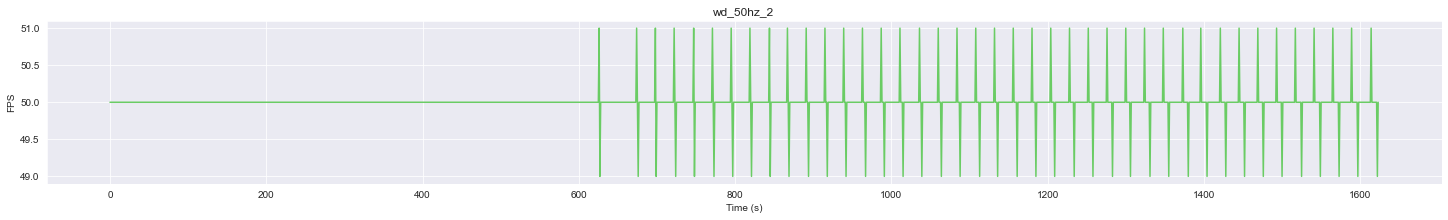

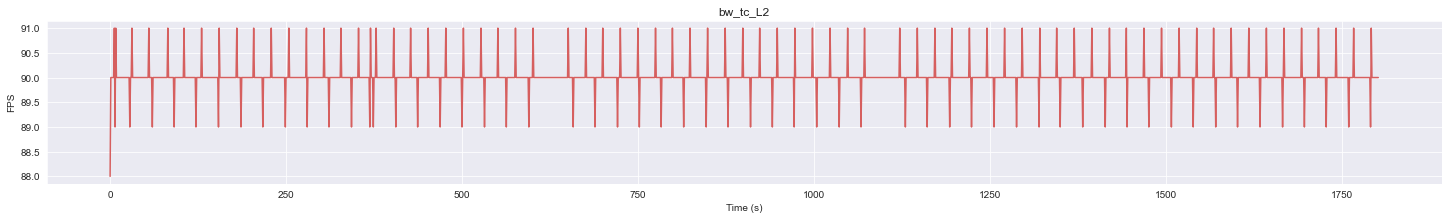

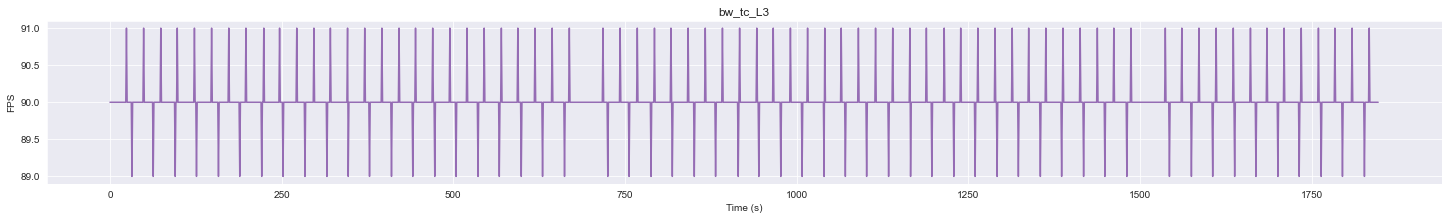

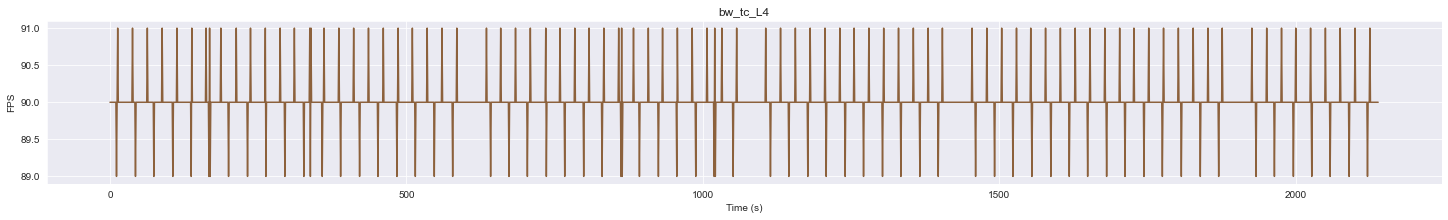

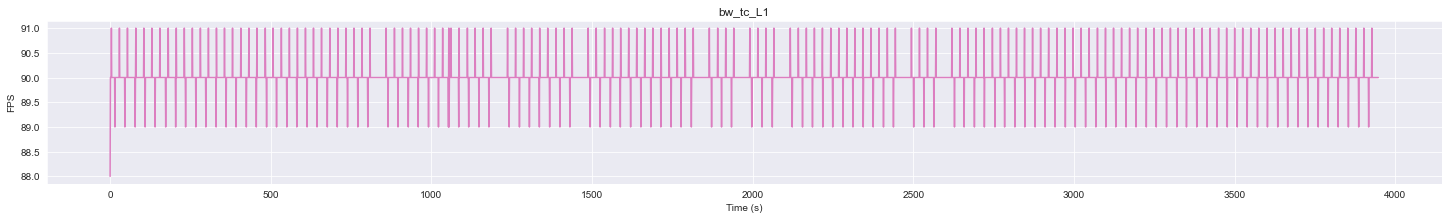

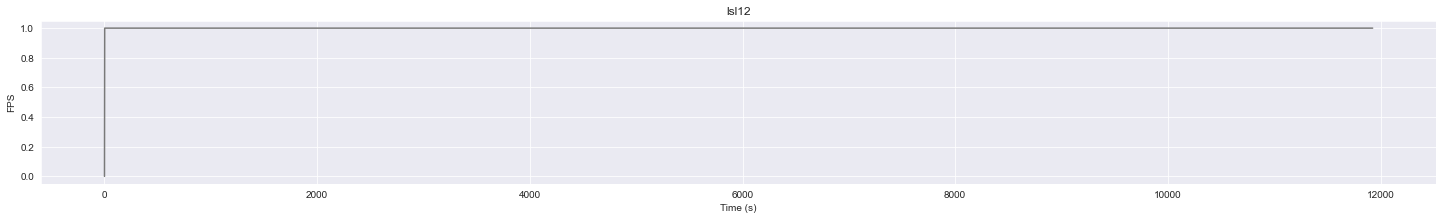

In [12]:
%matplotlib inline
sns.set_style("darkgrid")  # set seaborn plotting style
palette = itertools.cycle(sns.color_palette(palette="muted"))
for k in recordings:
    avg_fps = []
    temp = []
    next_sec = 1
    file = recordings[k]["file"].split(".")[0]
    for t in recordings[k]["unity"]["timestamps"]:
        if t <= next_sec:
            temp.append(t)
        else:
            avg_fps.append(len(temp))
            temp = []
            temp.append(t)
            next_sec += 1
    x = [i for i in range(len(avg_fps))]
    plt.figure(figsize=(25, 3))
    plt.title(file)
    plt.xlabel("Time (s)")
    plt.ylabel("FPS")
    sns.lineplot(x=x, y=avg_fps, color=next(palette))
plt.show()

How does `ftest_lsl12` look like?

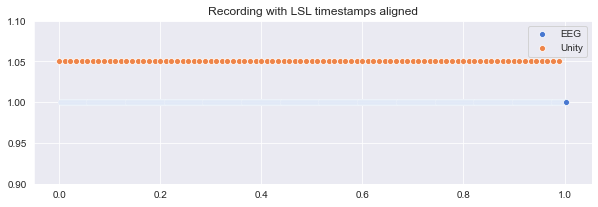

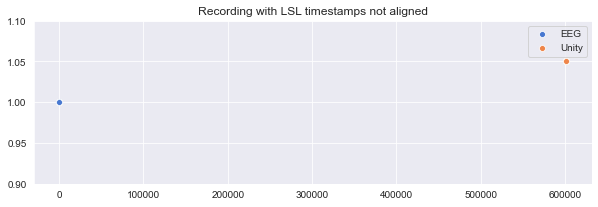

In [13]:
%matplotlib inline
sns.set_style("darkgrid")  # set seaborn plotting style
palette = itertools.cycle(sns.color_palette(palette="muted"))
plt.figure(figsize=(10, 3))
plt.title("Recording with LSL timestamps aligned")
ey = [1 for d in recordings[6]["eeg"]["timestamps"][:1024]]
uy = [1.05 for d in recordings[6]["unity"]["timestamps"][:90]]
sns.scatterplot(x=recordings[6]["eeg"]["timestamps"][:1024], y=ey, color=next(palette))
sns.scatterplot(x=recordings[6]["unity"]["timestamps"][:90], y=uy, color=next(palette))
plt.ylim(0.9, 1.1)
plt.legend(["EEG", "Unity"])
plt.show()
for k in recordings:
    if recordings[k]["file"].split(".")[0] == "lsl12":
        wrong = k
palette = itertools.cycle(sns.color_palette(palette="muted"))
plt.figure(figsize=(10, 3))
plt.title("Recording with LSL timestamps not aligned")
ey = [1 for d in recordings[wrong]["eeg"]["timestamps"][:1024]]
uy = [1.05 for d in recordings[wrong]["unity"]["timestamps"][:90]]
sns.scatterplot(
    x=recordings[wrong]["eeg"]["timestamps"][:1024], y=ey, color=next(palette)
)
sns.scatterplot(
    x=recordings[wrong]["unity"]["timestamps"][:90], y=uy, color=next(palette)
)
plt.ylim(0.9, 1.1)
plt.legend(["EEG", "Unity"])
plt.show()

Remove `lsl12` as wrong recording (timestamps not aligned)

In [14]:
# remove from the files list
to_remove = "lsl12"
# files.remove(to_remove)
for k in list(recordings):
    if recordings[k]["file"].split(".")[0] == to_remove:
        del recordings[k]  # remove from recordings dict

# update recordings keys as one is now missing
for i, k in enumerate(list(recordings)):
    recordings[i] = recordings.pop(k)

fnames = [recordings[k]["file"].split(".")[0] for k in recordings]

print("Files:")
display({i: name for i, name in enumerate(fnames)})

Files:


{0: 'bw1_sc',
 1: 'bw_sc_b1',
 2: 'bw_sc_b2',
 3: 'bw3_sc',
 4: 'bw2_sc',
 5: 'bw_sc_b3',
 6: 'bw_tc_r',
 7: 'wd_50hz_1',
 8: 'wd_1',
 9: 'wd_50hz_oc',
 10: 'wd_50hz_oc_sc',
 11: 'wd_50hz_oc_r',
 12: 'wd_50hz_2',
 13: 'bw_tc_L2',
 14: 'bw_tc_L3',
 15: 'bw_tc_L4',
 16: 'bw_tc_L1'}

How does the start of `bw_tc_L3` look like?

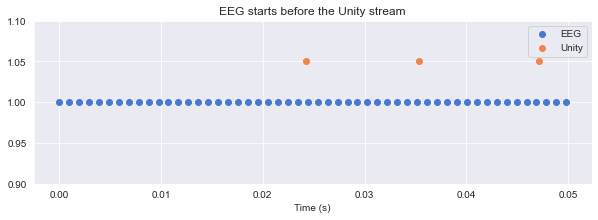

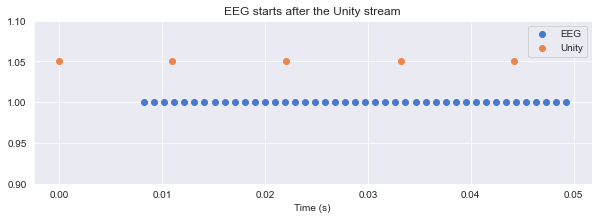

In [15]:
%matplotlib inline
sns.set_style("darkgrid")  # set seaborn plotting style
plt.figure(figsize=(10, 3))
plt.title("EEG starts before the Unity stream")
palette = itertools.cycle(sns.color_palette(palette="muted"))
e_selected = [x for x in recordings[wrong - 1]["eeg"]["timestamps"] if x < 0.05]
u_selected = [x for x in recordings[wrong - 1]["unity"]["timestamps"] if x < 0.05]
ey = [1 for d in e_selected]
uy = [1.05 for d in u_selected]
plt.scatter(x=e_selected, y=ey, color=next(palette))
plt.scatter(x=u_selected, y=uy, color=next(palette))
plt.ylim(0.9, 1.1)
plt.legend(["EEG", "Unity"])
plt.xlabel("Time (s)")
plt.show()

for k in recordings:
    if not recordings[k]["eeg_starts"]:
        wrong = k

plt.figure(figsize=(10, 3))
plt.title("EEG starts after the Unity stream")
palette = itertools.cycle(sns.color_palette(palette="muted"))
e_selected = [x for x in recordings[wrong]["eeg"]["timestamps"] if x < 0.05]
u_selected = [x for x in recordings[wrong]["unity"]["timestamps"] if x < 0.05]
ey = [1 for d in e_selected]
uy = [1.05 for d in u_selected]
plt.scatter(x=e_selected, y=ey, color=next(palette))
plt.scatter(x=u_selected, y=uy, color=next(palette))
plt.ylim(0.9, 1.1)
plt.legend(["EEG", "Unity"])
plt.xlabel("Time (s)")
plt.show()

#### __Timestamps comparison: original (O) vs corrected (C) vs file info (I)__

In [16]:
stats = pd.DataFrame()  # create empty dataframe
for k in recordings:
    comparison = {}
    file = recordings[k]["file"].split(".")[0]  # remove extension from filename
    o_c = {"time_stamps": "O", "timestamps": "C"}
    for key in list(o_c.keys()):  # avoid duplicate code with different keys
        # for original and corrected timestamps
        u_ts = recordings[k]["unity"][key]
        e_ts = recordings[k]["eeg"][key]
        u_first = u_ts[0]
        u_last = u_ts[-1]
        e_first = e_ts[0]
        e_last = e_ts[-1]
        u_length = u_last - u_first
        e_length = e_last - e_first

        val = o_c[key]

        comparison[f"First EEG ({val})"] = e_first
        comparison[f"First Unity ({val})"] = u_first
        comparison[f"Last EEG ({val})"] = e_last
        comparison[f"Last Unity ({val})"] = u_last
        comparison[f"Length EEG ({val})"] = e_length
        comparison[f"Length Unity ({val})"] = u_length
        comparison[f"Sample count EEG ({val})"] = len(e_ts)
        comparison[f"Sample count Unity ({val})"] = len(u_ts)
        comparison[f"Start diff ({val})"] = u_first - e_first
        comparison[f"End diff ({val})"] = e_last - u_last
        comparison[f"Length diff ({val})"] = abs(u_length - e_length)

    # file info
    u_info = recordings[k]["unity"]["info"]
    e_info = recordings[k]["eeg"]["info"]
    i_u_first = u_info["first_timestamp"]
    i_u_last = u_info["last_timestamp"]
    i_e_first = e_info["first_timestamp"]
    i_e_last = e_info["last_timestamp"]
    i_e_length = float(i_e_last) - float(i_e_first)
    i_u_length = float(i_u_last) - float(i_u_first)

    comparison["First EEG (I)"] = i_e_first
    comparison["First Unity (I)"] = i_u_first
    comparison["Last EEG (I)"] = i_e_last
    comparison["Last Unity (I)"] = i_u_last
    comparison["Length EEG (I)"] = i_e_length
    comparison["Length Unity (I)"] = i_u_length
    comparison["Sample count EEG (I)"] = e_info["sample_count"]
    comparison["Sample count Unity (I)"] = u_info["sample_count"]
    comparison["Start diff (I)"] = float(i_u_first) - float(i_e_first)
    comparison[f"End diff ({val})"] = float(i_e_last) - float(i_u_last)
    comparison["Length diff (I)"] = abs(i_u_length - i_e_length)
    comparison["Stream creation (EEG)"] = e_info["created_at"]
    comparison["Stream creation (Unity)"] = u_info["created_at"]

    # order keys alphabetically
    comparison = dict(sorted(comparison.items()))
    current = pd.DataFrame.from_dict(
        comparison, orient="index", columns=[file], dtype=float
    )
    if stats.empty:  # first file
        stats = current
    else:
        stats = pd.merge(stats, current, left_index=True, right_index=True)

display(stats)

,bw1_sc,bw_sc_b1,bw_sc_b2,bw3_sc,bw2_sc,bw_sc_b3,bw_tc_r,wd_50hz_1,wd_1,wd_50hz_oc,wd_50hz_oc_sc,wd_50hz_oc_r,wd_50hz_2,bw_tc_L2,bw_tc_L3,bw_tc_L4,bw_tc_L1
End diff (C),0.00886,0.48944,-0.00012,0.01795,0.01092,-0.48685,517313.23088,431.61271,-44.44737,-517313.15832,-0.01381,517313.18879,-9585.99102,6095.24820,6095.25715,-72115.48987,-16.29851
End diff (O),0.02623,0.50496,0.01367,0.02941,0.02928,-0.47287,0.01980,0.01138,0.01938,0.03094,0.00271,-0.00380,-0.00673,0.00862,0.01063,0.00988,0.00289
First EEG (C),0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00454,0.00000,0.00000,0.00081,0.00000,0.00000,0.00000,0.00000,0.00826,0.00000,0.00000
First EEG (I),597683.74404,598491.29066,598677.04580,597976.03226,597824.31215,598964.45703,527338.48356,14391.39276,2794.60018,1073.66513,521416.40722,523947.12053,1750.36886,11538.20545,13464.11651,3091.88329,4099.21100
First EEG (O),597683.72940,598491.27394,598677.02717,597976.01532,597824.29413,598964.43842,527338.47078,14391.37389,2794.58610,1073.65142,521416.38892,523947.10583,1750.35710,11538.18904,13464.10426,3091.86438,4099.19373
First Unity (C),0.00582,0.02726,0.02200,0.01003,0.01060,0.01224,0.00000,0.00722,0.00221,0.00000,0.03647,0.01127,0.01149,0.02518,0.00000,0.00633,0.02429
First Unity (I),597683.73523,598491.30121,598677.04918,597976.02536,597824.30474,598964.45067,10025.24155,13959.76563,2839.03846,518386.81685,521416.42540,6633.92331,11336.33450,5442.97078,7368.84314,75207.36781,4115.55243
First Unity (O),597683.73522,598491.30120,598677.04917,597976.02535,597824.30473,598964.45066,527338.46624,14391.38111,2794.58832,1073.65061,521416.42539,523947.11710,1750.36859,11538.21422,13464.09599,3091.87072,4099.21802
Last EEG (C),122.03219,125.03236,134.03251,136.53252,138.53250,145.03270,439.51447,623.51098,624.01216,1221.02208,1469.03375,1559.00509,1623.99985,1803.03708,1848.51554,2140.51401,3948.01621
Last EEG (I),597805.74422,598616.29079,598811.04591,598112.53638,597962.80827,599109.45715,527777.96326,15014.87300,3418.58396,2294.65537,522885.40616,525506.09563,3374.34453,13341.21339,15312.59637,5232.36425,8047.19862


Differences with Average

In [17]:
# collect indexes (rows) containing "diff" to display and calculate the AVG
diff_indexes = [index for index in stats.index if "diff" in index]
diffs = stats.loc[diff_indexes]
diffs_mean = pd.DataFrame(diffs.mean(axis=1), columns=["AVG"])
diffs = pd.merge(diffs, diffs_mean, left_index=True, right_index=True)
display(diffs.style.applymap(color_checks, subset=["AVG"]))

,bw1_sc,bw_sc_b1,bw_sc_b2,bw3_sc,bw2_sc,bw_sc_b3,bw_tc_r,wd_50hz_1,wd_1,wd_50hz_oc,wd_50hz_oc_sc,wd_50hz_oc_r,wd_50hz_2,bw_tc_L2,bw_tc_L3,bw_tc_L4,bw_tc_L1,AVG
End diff (C),0.008856,0.489438,-0.000117,0.017950,0.010925,-0.486849,517313.230876,431.612712,-44.447372,-517313.158323,-0.013813,517313.188787,-9585.991018,6095.248195,6095.257151,-72115.489867,-16.298512,26363.128178
End diff (O),0.026226,0.504958,0.013666,0.029413,0.029281,-0.472871,0.019798,0.011379,0.019382,0.030945,0.002706,-0.003804,-0.006731,0.008625,0.010634,0.009878,0.002887,0.013904
Length diff (C),0.032048,0.532217,0.035661,0.039445,0.039881,0.460628,0.015258,0.018601,0.021596,0.030131,0.039174,0.007469,0.004758,0.033802,0.002369,0.016212,0.027173,0.079790
Length diff (I),0.000042,0.499989,0.003256,0.011047,0.003507,0.493215,0.011138,0.014422,0.009094,0.006604,0.004363,0.008439,0.025379,0.013522,0.016211,0.005340,0.042923,0.068735
Length diff (O),0.032048,0.532217,0.035661,0.039445,0.039881,0.460628,0.015258,0.018601,0.021596,0.030131,0.039174,0.007469,0.004758,0.033802,0.002369,0.016212,0.027173,0.079790
Start diff (C),0.005823,0.027259,0.021995,0.010033,0.010600,0.012243,-0.004540,0.007222,0.002214,-0.000814,0.036468,0.011273,0.011489,0.025177,-0.008265,0.006333,0.024286,0.011694
Start diff (I),-0.008814,0.010551,0.003372,-0.006903,-0.007418,-0.006365,-517313.242014,-431.627134,44.438278,517313.151719,0.018176,-517313.197226,9585.965639,-6095.234673,-6095.273362,72115.484527,16.341435,-26363.128836
Start diff (O),0.005823,0.027259,0.021995,0.010033,0.010600,0.012243,-0.004540,0.007222,0.002214,-0.000814,0.036468,0.011273,0.011489,0.025177,-0.008265,0.006333,0.024286,0.011694


Show just the start end ending differences

In [18]:
display(
    diffs.loc[["Start diff (O)", "End diff (O)"], :].style.applymap(
        color_checks, subset=["AVG"]
    )
)

,bw1_sc,bw_sc_b1,bw_sc_b2,bw3_sc,bw2_sc,bw_sc_b3,bw_tc_r,wd_50hz_1,wd_1,wd_50hz_oc,wd_50hz_oc_sc,wd_50hz_oc_r,wd_50hz_2,bw_tc_L2,bw_tc_L3,bw_tc_L4,bw_tc_L1,AVG
Start diff (O),0.005823,0.027259,0.021995,0.010033,0.010600,0.012243,-0.004540,0.007222,0.002214,-0.000814,0.036468,0.011273,0.011489,0.025177,-0.008265,0.006333,0.024286,0.011694
End diff (O),0.026226,0.504958,0.013666,0.029413,0.029281,-0.472871,0.019798,0.011379,0.019382,0.030945,0.002706,-0.003804,-0.006731,0.008625,0.010634,0.009878,0.002887,0.013904


#### __Descriptive statistics: Unity and EEG samples time distance__

In [19]:
u_stats = pd.DataFrame()  # create empty dataframe
u_dist = []
e_dist = []
for k in recordings:
    file = recordings[k]["file"].split(".")[0]  # remove extension from filename
    # corrected timestamps
    u_ts = recordings[k]["unity"]["timestamps"]
    e_ts = recordings[k]["eeg"]["timestamps"]
    # compute the time distance between samples
    u = [u_ts[i + 1] - u_ts[i] for i in range(len(u_ts) - 1)]
    e = [e_ts[i + 1] - e_ts[i] for i in range(len(e_ts) - 1)]
    u_dist.append(u)
    e_dist.append(e)
    # store as dataframe (easier to compute descriptive statistics)
    u = pd.DataFrame(np.array(u), columns=[file])
    e = pd.DataFrame(np.array(e), columns=[file])
    if u_stats.empty:  # first file
        u_stats = u.describe()
        e_stats = e.describe()
    else:  # after first file, merge current stats with previous acumulated stats
        u_stats = pd.merge(u_stats, u.describe(), left_index=True, right_index=True)
        e_stats = pd.merge(e_stats, e.describe(), left_index=True, right_index=True)

u_mean = pd.DataFrame(u_stats.mean(axis=1), columns=["AVG"])
e_mean = pd.DataFrame(e_stats.mean(axis=1), columns=["AVG"])
u_stats = pd.merge(u_stats, u_mean, left_index=True, right_index=True)
e_stats = pd.merge(e_stats, e_mean, left_index=True, right_index=True)

__Unity__

In [20]:
display(u_stats.style.applymap(color_checks, subset=["AVG"]))

,bw1_sc,bw_sc_b1,bw_sc_b2,bw3_sc,bw2_sc,bw_sc_b3,bw_tc_r,wd_50hz_1,wd_1,wd_50hz_oc,wd_50hz_oc_sc,wd_50hz_oc_r,wd_50hz_2,bw_tc_L2,bw_tc_L3,bw_tc_L4,bw_tc_L1,AVG
count,10981.000000,11206.000000,12061.000000,12285.000000,12465.000000,13096.000000,39558.000000,31175.000000,56165.000000,61050.000000,73450.000000,77949.000000,81200.000000,162286.000000,166381.000000,192663.000000,355351.000000,80548.352941
mean,0.011110,0.011110,0.011110,0.011111,0.011111,0.011110,0.011110,0.020000,0.011110,0.020000,0.020000,0.020000,0.020000,0.011110,0.011110,0.011110,0.011110,0.013725
std,0.001141,0.001266,0.001182,0.001209,0.001135,0.001251,0.000781,0.004428,0.000940,0.004419,0.004420,0.004433,0.004418,0.000844,0.000840,0.000843,0.000912,0.002027
min,0.000023,0.000023,0.000023,0.000023,0.000023,0.000024,0.000007,0.009654,0.000816,0.009767,0.009222,0.007915,0.009490,0.000022,0.000022,0.000021,0.000022,0.002770
25%,0.011022,0.011026,0.011020,0.011023,0.011022,0.011019,0.011066,0.021973,0.011041,0.022015,0.021970,0.021732,0.022002,0.011065,0.011065,0.011069,0.011059,0.014246
50%,0.011109,0.011110,0.011111,0.011110,0.011108,0.011111,0.011105,0.022169,0.011108,0.022168,0.022158,0.022139,0.022170,0.011106,0.011106,0.011106,0.011107,0.014359
75%,0.011195,0.011194,0.011198,0.011194,0.011196,0.011202,0.011146,0.022267,0.011176,0.022256,0.022271,0.022324,0.022252,0.011148,0.011148,0.011143,0.011155,0.014439
max,0.022469,0.022343,0.022632,0.022717,0.022827,0.025182,0.022598,0.023734,0.029115,0.024201,0.029973,0.033678,0.023890,0.023186,0.023030,0.023148,0.022965,0.024570


__EEG__

In [21]:
display(e_stats.style.applymap(color_checks, subset=["AVG"]))

,bw1_sc,bw_sc_b1,bw_sc_b2,bw3_sc,bw2_sc,bw_sc_b3,bw_tc_r,wd_50hz_1,wd_1,wd_50hz_oc,wd_50hz_oc_sc,wd_50hz_oc_r,wd_50hz_2,bw_tc_L2,bw_tc_L3,bw_tc_L4,bw_tc_L1,AVG
count,124959.000000,128031.000000,137247.000000,139807.000000,141855.000000,148511.000000,450047.000000,638463.000000,638975.000000,1250303.000000,1504255.000000,1596383.000000,1662943.000000,1846271.000000,1892831.000000,2191839.000000,4042655.000000,1090316.176471
mean,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977
std,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
min,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977
25%,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977
50%,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977
75%,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977
max,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977


#### __Time distribution plots__

EEG boxen plots (strip plots too slow because of high sampling rate)

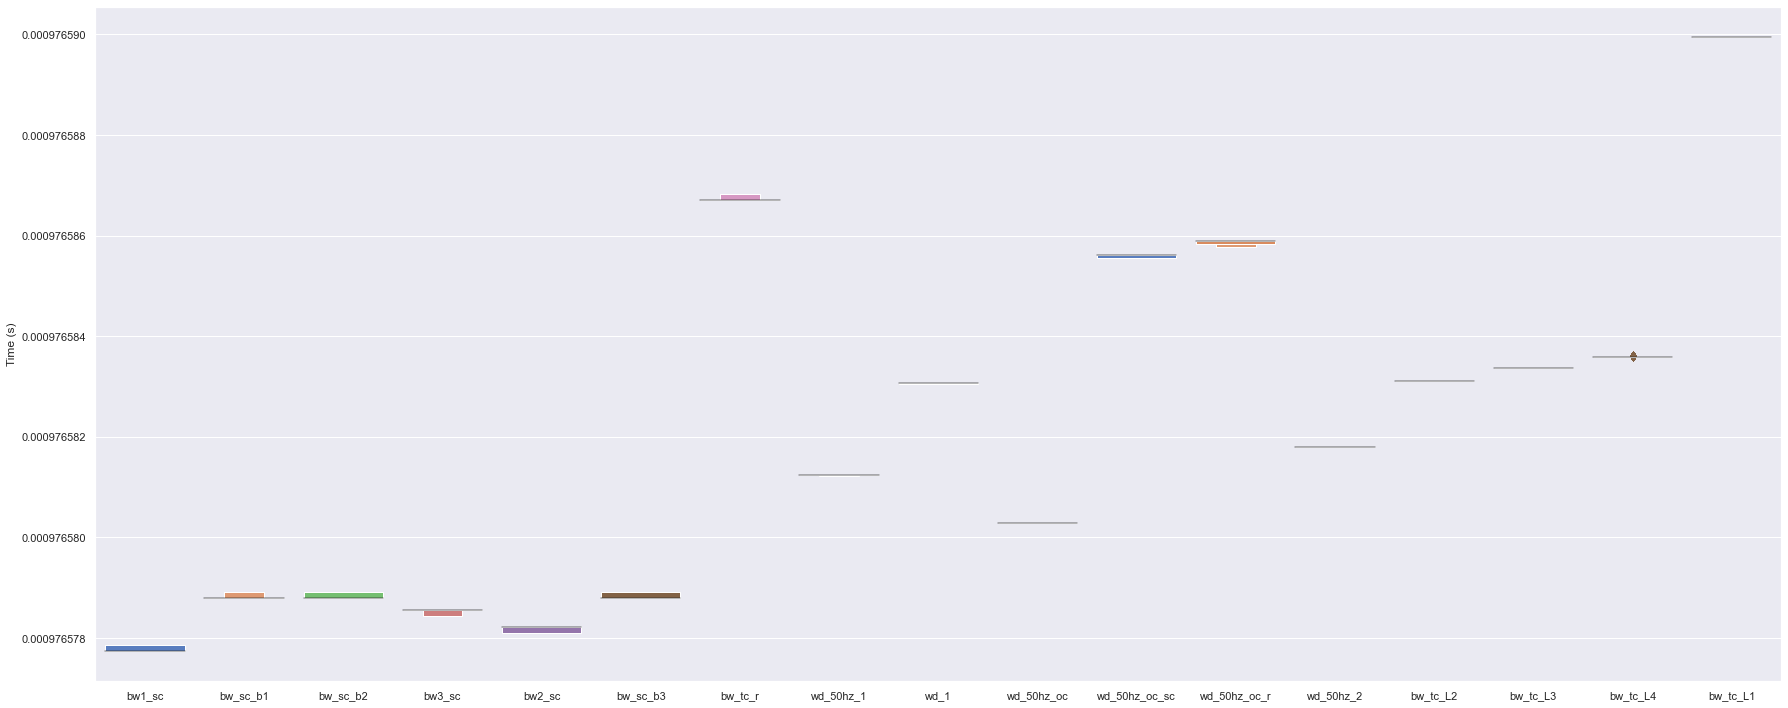

In [22]:
sns.set(rc={"figure.figsize": (25, 10)})  # set figure size
sns.set_style("darkgrid")  # set seaborn plotting style
g = sns.boxenplot(data=e_dist, palette="muted")
g.set_xticklabels(fnames)
plt.ticklabel_format(style="plain", axis="y", useOffset=False)
plt.ylabel("Time (s)")
plt.tight_layout()
plt.show()

Unity boxen plots: the samples time distance is rather around 0, around 11 ms or around 22 ms. But how is the distribution in each of the 3 distances?

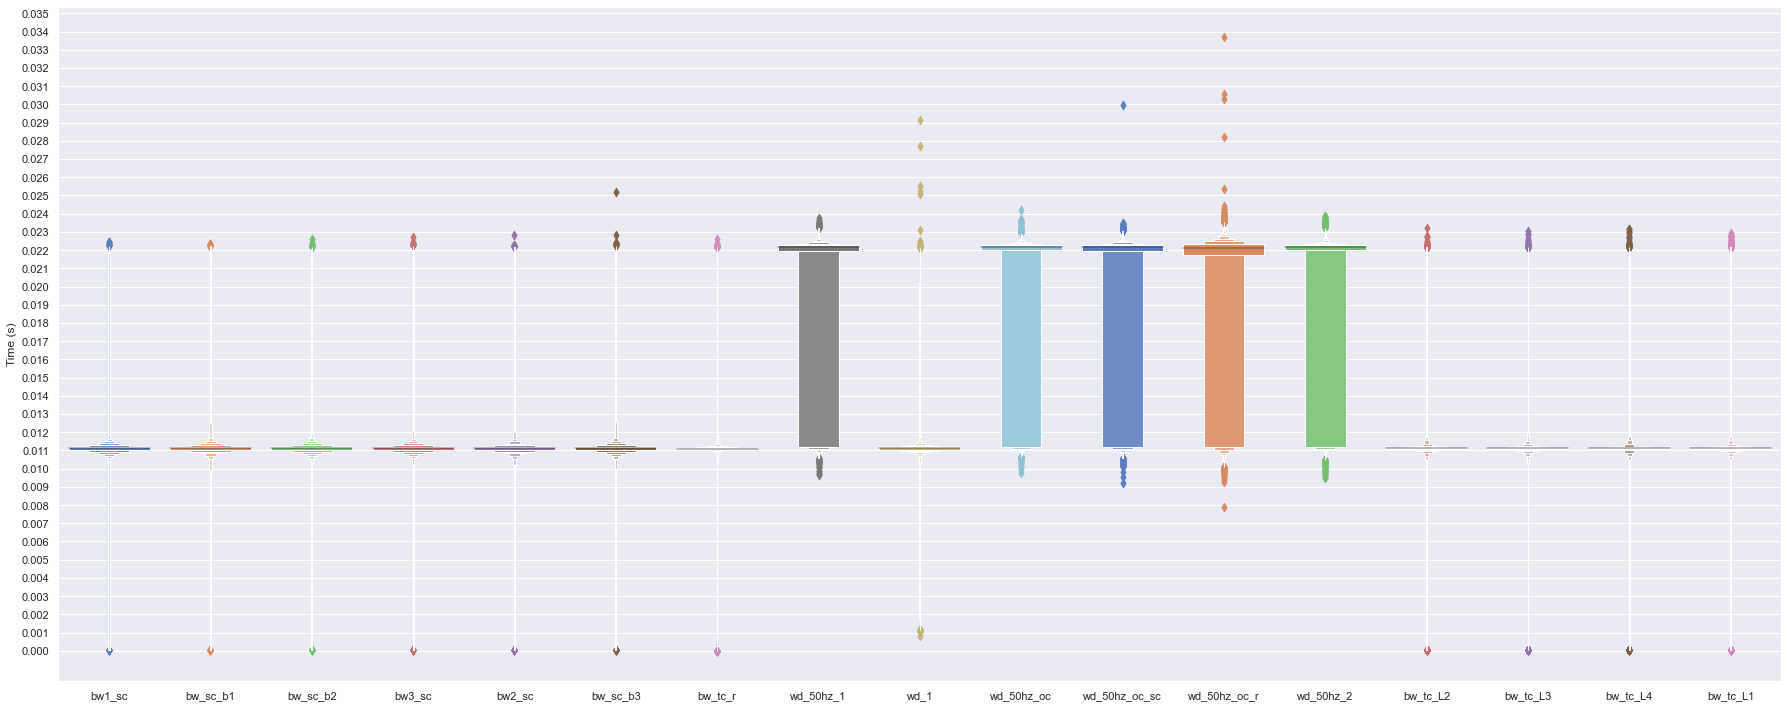

In [23]:
sns.set(rc={"figure.figsize": (25, 10)})  # set figure size
sns.set_style("darkgrid")  # set seaborn plotting style
g = sns.boxenplot(data=u_dist, palette="muted")
g.set_xticklabels(fnames)
g.set_yticks(np.arange(0, g.get_ylim()[1], 0.001))
plt.ticklabel_format(style="plain", axis="y", useOffset=False)
plt.ylabel("Time (s)")
plt.tight_layout()
plt.show()

Unity strip plots: the biggest density is around 11 ms, then rather 22 ms and finally 0. Still not clear enough.

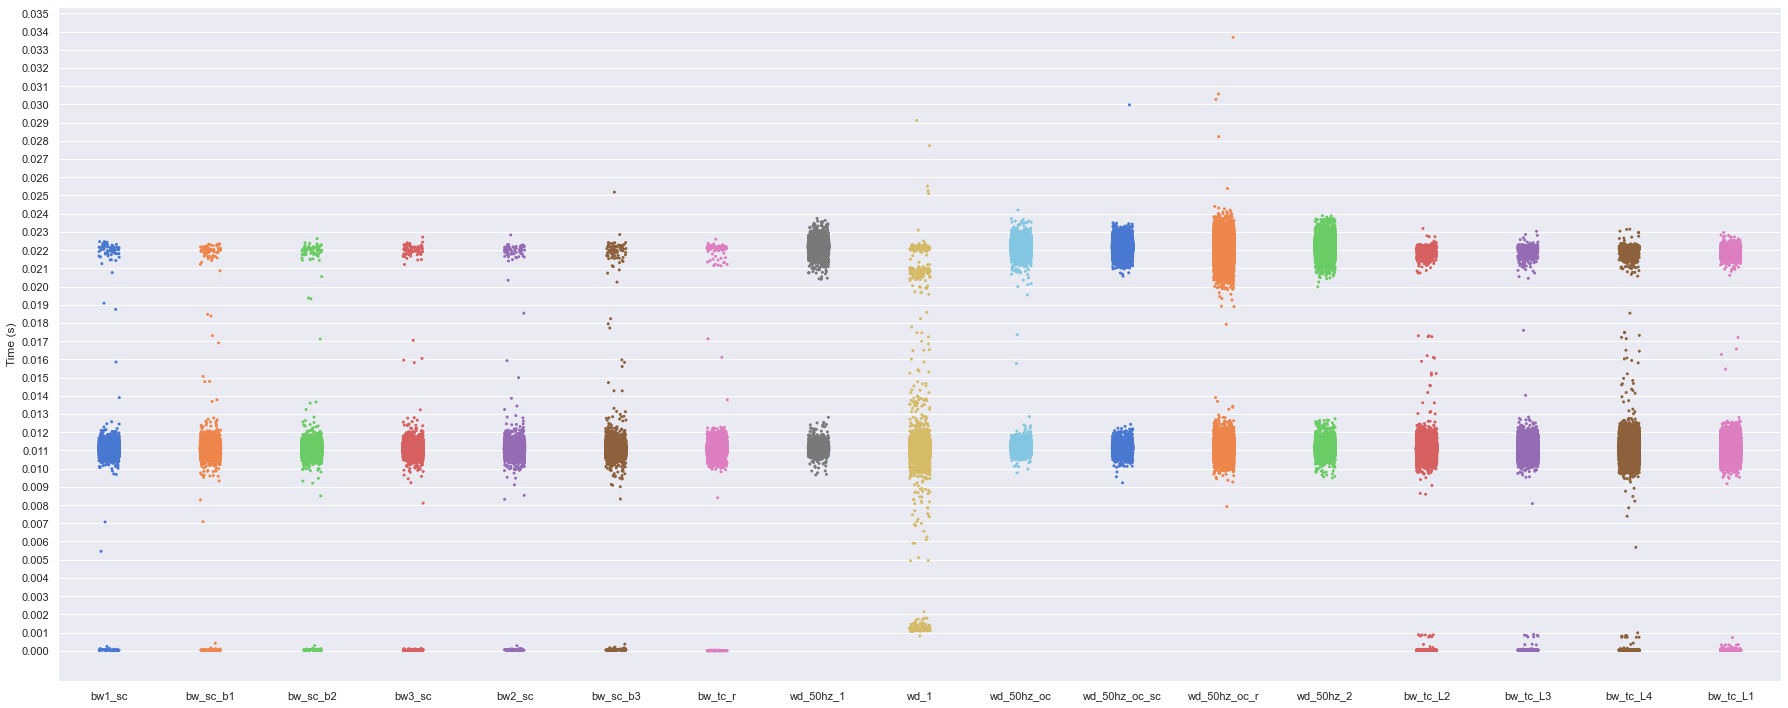

In [24]:
sns.set(rc={"figure.figsize": (25, 10)})  # set figure size
sns.set_style("darkgrid")  # set seaborn plotting style
strip_plot(u_dist, fnames)

Strip plots: better density visualization but still not clear how exactly are they distributed.

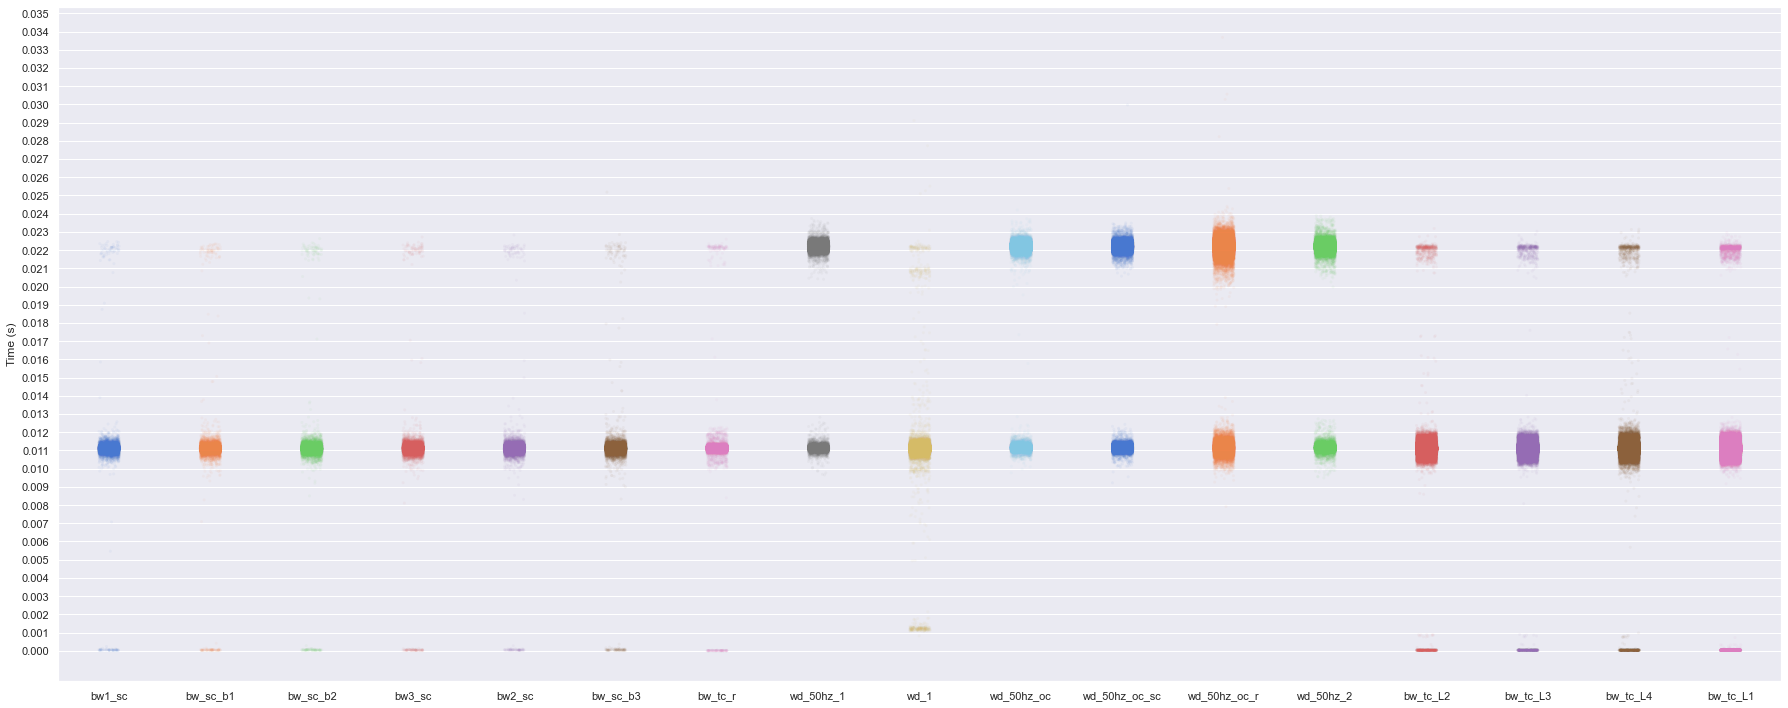

In [25]:
sns.set(rc={"figure.figsize": (25, 10)})  # set figure size
sns.set_style("darkgrid")  # set seaborn plotting style
strip_plot(u_dist, fnames, 0.05)  # change alpha for a stronger density contrast

Unity Strip + Dist plots: optimal population density visualization.

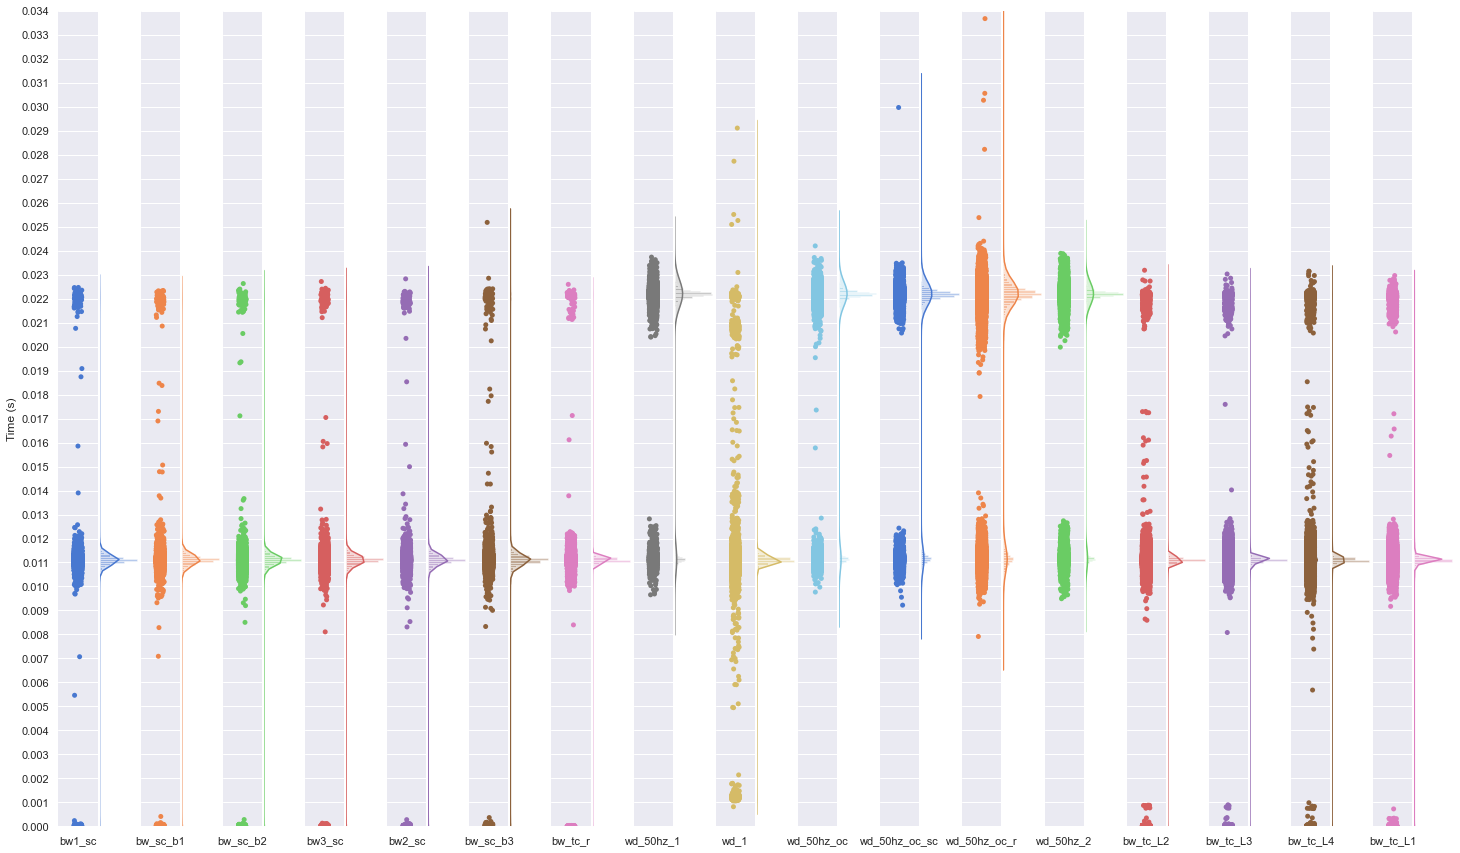

In [26]:
%matplotlib inline
nplots = len(u_dist) * 2  # number of subplots
palette = itertools.cycle(sns.color_palette(palette="muted"))

# define subplots
fig = plt.figure(figsize=(25, 15))
cols = 1
gs = fig.add_gridspec(cols, nplots)

y_max = 0
# since sharey does not work in this context by adding subplots one by one
for dist in u_dist:  # get the maximum y value to set the same scale on subplots
    if max(dist) > y_max:
        y_max = max(dist)

step = 0.001
ticks = np.arange(0, y_max + step, step)
kde = {"shade": True}
j = 0
for i in range(nplots):
    style = "darkgrid" if i % 2 == 0 else "white"
    with sns.axes_style(style):
        ax = fig.add_subplot(gs[i])
        if i % 2 == 0:
            color = next(palette)
            sns.stripplot(x=u_dist[j], ax=ax, orient="v", color=color)
            ax.set_xticklabels([fnames[j]])  # filename
            ax.set_ylim(0, y_max)
            ax.set_yticks(ticks)
        else:
            sns.distplot(
                u_dist[j],
                ax=ax,
                vertical=True,
                norm_hist=True,
                bins=250,
                kde_kws=kde,
                color=color,
            )
            ax.set_ylim(0, y_max)
            ax.set_yticks(ticks)
            ax.set_xticklabels([])
            sns.despine(left=True, bottom=True)
            j += 1
        if i != 0:
            ax.set_yticklabels([])


plt.subplots_adjust(wspace=0.05)

fig.axes[0].set_ylabel("Time (s)")
plt.show()

__Odd Datapoints__

In [27]:
odds = {}
odds["N"] = []
odds["N 0"] = []
odds["% 0"] = []
odds["N Middle"] = []
odds["% Middle"] = []
odds["N 2x"] = []
odds["% 2x"] = []
odds["N 2x -> 0"] = []
odds["% 2x -> 0"] = []
odds["N 0 -> 2x"] = []
odds["% 0 -> 2x"] = []

for k in recordings:
    zero = 0
    twice = 0
    taz = 0
    zat = 0
    middle = 0
    length = len(u_dist[k])
    odds["N"].append(length)
    for i in range(length):
        if u_dist[k][i] < 0.010:
            zero += 1
            if i > 1 and u_dist[k][i - 1] > 0.012:
                zat += 1
        elif u_dist[k][i] > 0.012:
            twice += 1
            if i > 1 and u_dist[k][i - 1] > 0.010:
                taz += 1
        else:
            middle += 1
    odds["N 0"].append(zero)
    odds["% 0"].append(zero * 100 / length)
    odds["N Middle"].append(middle)
    odds["% Middle"].append(middle * 100 / length)
    odds["N 2x"].append(twice)
    odds["% 2x"].append(twice * 100 / length)
    odds["N 2x -> 0"].append(taz)
    odds["% 2x -> 0"].append(taz * 100 / length)
    odds["N 0 -> 2x"].append(zat)
    odds["% 0 -> 2x"].append(zat * 100 / length)

odds = pd.DataFrame(odds, index=fnames)
display(odds)

,N,N 0,% 0,N Middle,% Middle,N 2x,% 2x,N 2x -> 0,% 2x -> 0,N 0 -> 2x,% 0 -> 2x
bw1_sc,10981,62,0.56461,10843,98.74328,76,0.69210,38,0.34605,25,0.22767
bw_sc_b1,11206,89,0.79422,11007,98.22417,110,0.98162,53,0.47296,41,0.36588
bw_sc_b2,12061,78,0.64671,11890,98.58221,93,0.77108,53,0.43943,38,0.31507
bw3_sc,12285,84,0.68376,12099,98.48596,102,0.83028,54,0.43956,36,0.29304
bw2_sc,12465,76,0.60971,12286,98.56398,103,0.82631,55,0.44124,33,0.26474
bw_sc_b3,13096,103,0.78650,12859,98.19029,134,1.02321,76,0.58033,62,0.47343
bw_tc_r,39558,96,0.24268,39320,99.39835,142,0.35897,81,0.20476,36,0.09101
wd_50hz_1,31175,5,0.01604,6185,19.83962,24985,80.14435,24979,80.12510,5,0.01604
wd_1,56165,365,0.64987,55446,98.71984,354,0.63029,172,0.30624,149,0.26529
wd_50hz_oc,61050,2,0.00328,12148,19.89844,48900,80.09828,48897,80.09337,2,0.00328


#### __Data preview__

How does the data look like? Plot of the 4 streams (Unity color, Unity audio, EEG diode, EEG microphone)

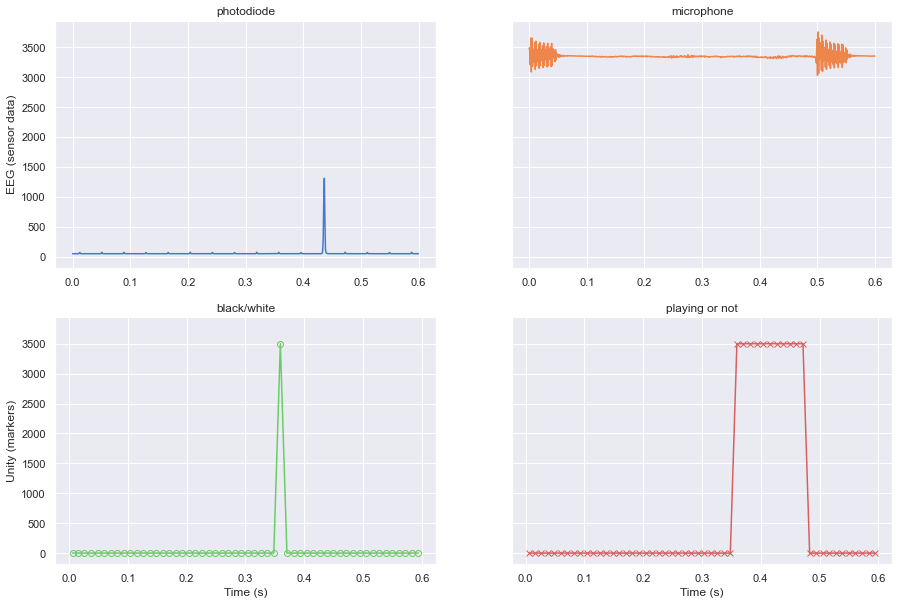

In [28]:
sns.set(rc={"figure.figsize": (14, 5)})  # set figure size
sns.set_style("darkgrid")  # set seaborn plotting style
palette = itertools.cycle(sns.color_palette(palette="muted"))

f_n = -0.1  # starting point (s)
s_n = 0.6  # ending point (s)

start_e = 1024 * f_n  # eeg sampling rate = 1024
start_u = 90 * f_n  # unity sampling rate = 90

e_samples = 1024 * s_n  # N of eeg in 5 s
u_samples = 90 * s_n  # N of unity in 5 s
u_height = 3500  # factor to improve unity (true/1) values visualization

file = recordings[0]["file"].split(".")[0]
e = copy.deepcopy(recordings[0]["eeg"])
u = copy.deepcopy(recordings[0]["unity"])
e_t = e["timestamps"]
u_t = u["timestamps"]
e_a = e["audio"]
e_c = e["color"]
u_c = u["color"]
u_a = u["audio"]

# fix diff array sizes for unity color and audio arrays
u_diff = len(u_c) - len(u_t)
if u_diff > 0:
    # remove the diff from the end of the array
    u_c = u_c[:-u_diff]
elif u_diff < 0:
    # add the diff from the end of the array
    for i in range(abs(u_diff)):
        u_c = np.append(u_c, u_c[-1])

# select range of timestamps, diode and microphone values (eeg)
e_time_selection = e_t[(e_t > f_n) & (e_t < s_n)]
e_color_selection = e_c[(e_t > f_n) & (e_t < s_n)]
e_audio_selection = e_a[(e_t > f_n) & (e_t < s_n)]

# select range of timestamps, color and audio values (unity)
u_time_selection = u_t[(u_t > f_n) & (u_t < s_n)]
u_color_selection = u_c[(u_t > f_n) & (u_t < s_n)]
u_audio_selection = u_a[(u_t > f_n) & (u_t < s_n)]
preview = [
    ["black/white", u_time_selection, u_color_selection * u_height],
    ["playing or not", u_time_selection, u_audio_selection * u_height],
    ["photodiode", e_time_selection, e_color_selection * 0.05],
    ["microphone", e_time_selection, e_audio_selection * 1.5],
]

# plot the selected range to compare eeg vs unity values
nplots = 4  # number of subplots

# define subplots
fig, axes = plt.subplots(nrows=2, ncols=int(nplots / 2), figsize=(15, 10), sharey=True)

axes[0, 0].plot(preview[2][1], preview[2][2], color=next(palette))
axes[0, 0].set_title(preview[2][0])
axes[0, 1].plot(preview[3][1], preview[3][2], color=next(palette))
axes[0, 1].set_title(preview[3][0])
axes[1, 0].plot(
    preview[0][1],
    preview[0][2],
    marker="o",
    color=next(palette),
    markerfacecolor="None",
)
axes[1, 0].set_title(preview[0][0])
axes[1, 1].plot(preview[1][1], preview[1][2], marker="x", color=next(palette))
axes[1, 1].set_title(preview[1][0])

for ax in axes[1, :]:
    ax.set_xlabel("Time (s)")  # set x-axis label
axes[0, 0].set_ylabel("EEG (sensor data)")  # set y-axis label
axes[1, 0].set_ylabel("Unity (markers)")  # set y-axis label
plt.show()

Short preview of all recordings

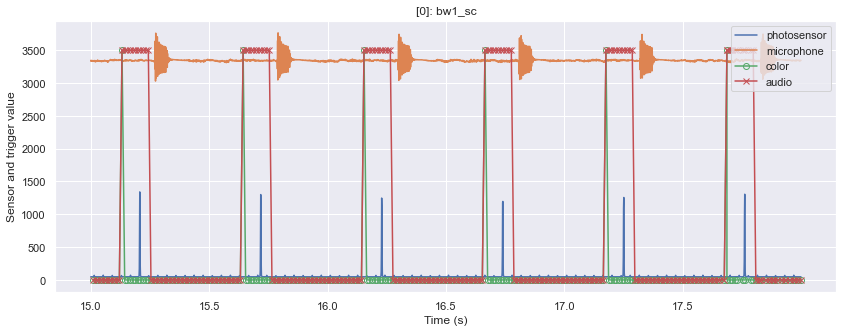

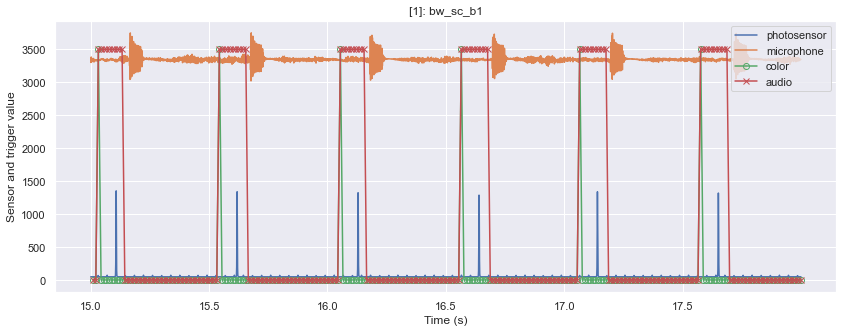

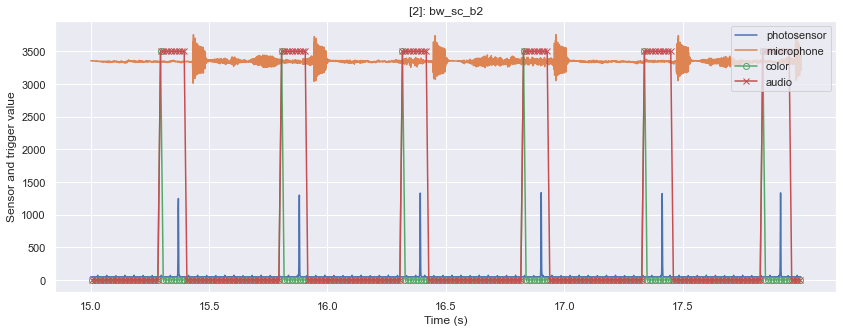

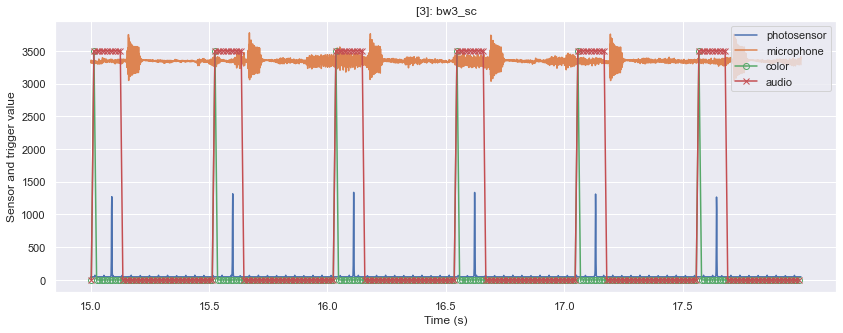

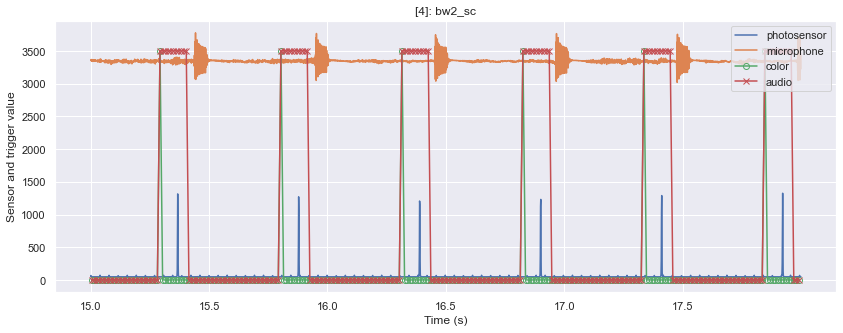

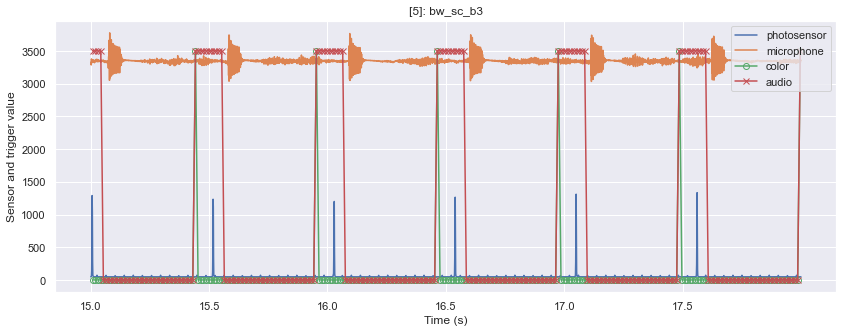

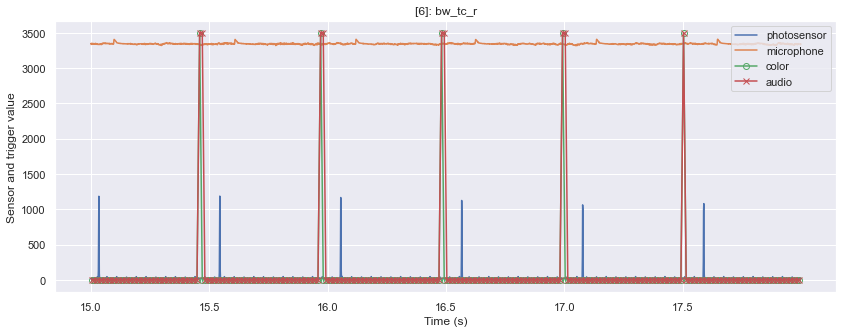

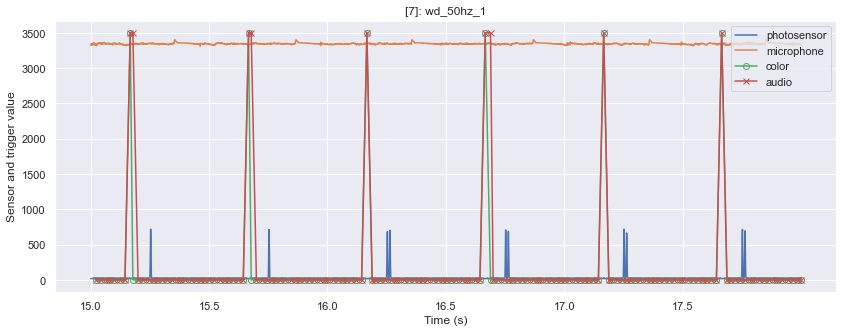

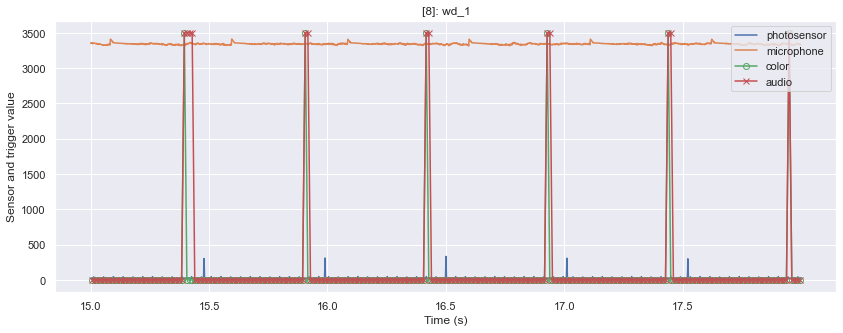

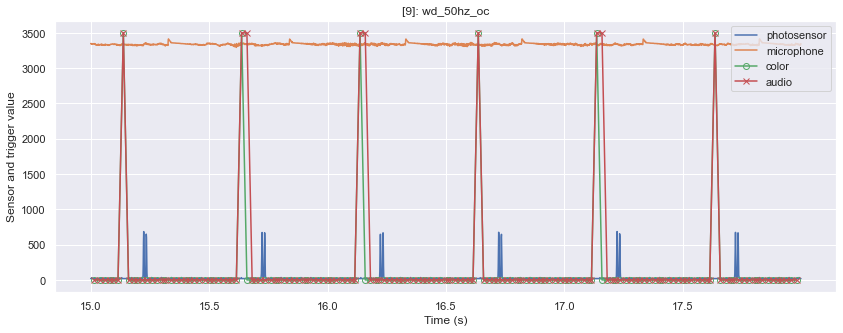

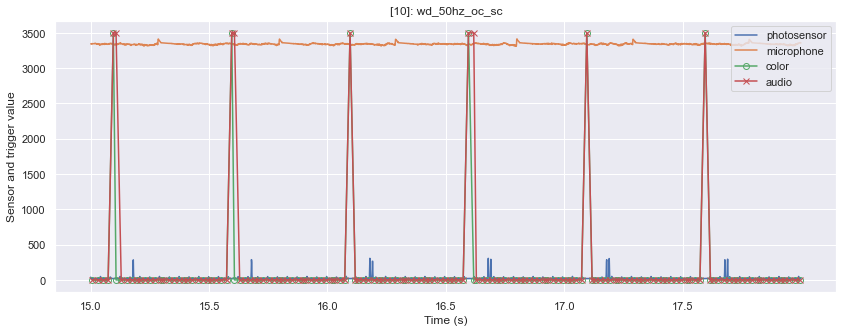

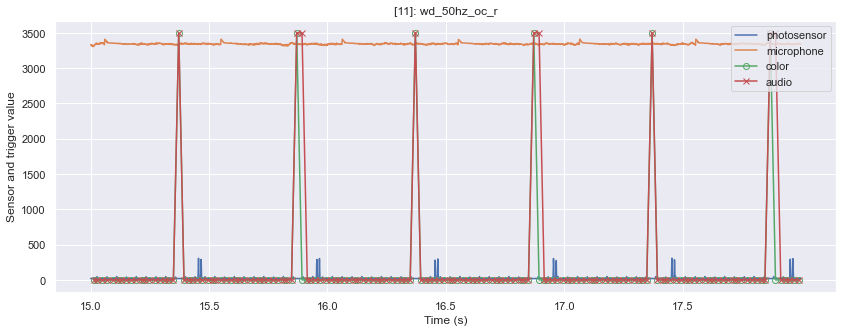

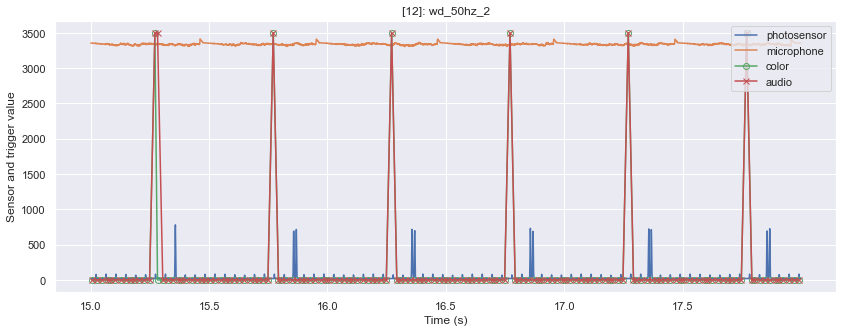

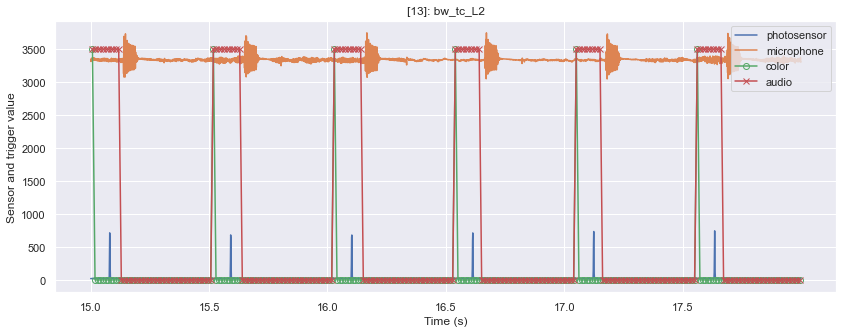

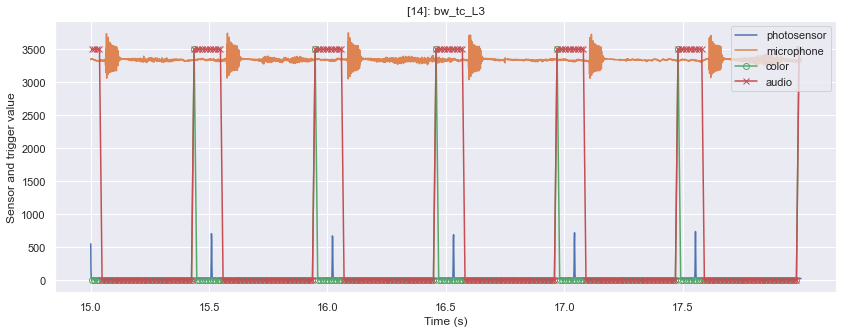

15: bw_tc_L4 -> u_c is 1 sample/s larger than u_t


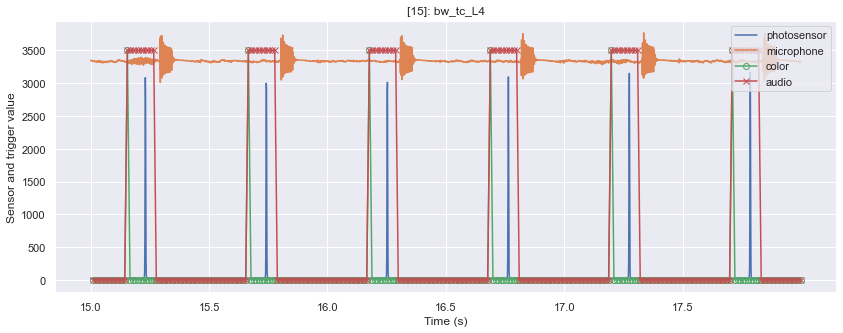

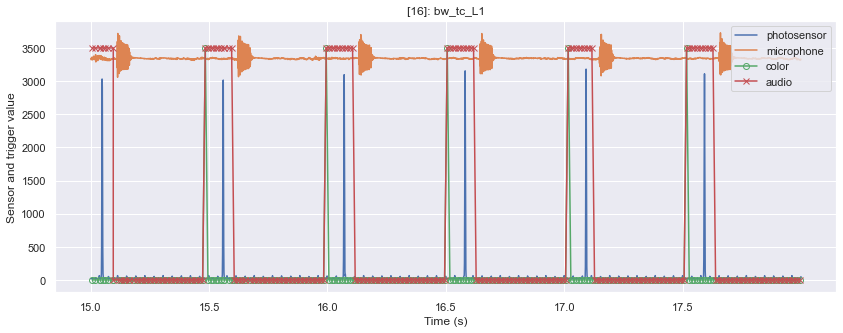

In [29]:
# interactive: widget, not interactive: inline
sns.set(rc={"figure.figsize": (14, 5)})  # set figure size
sns.set_style("darkgrid")  # set seaborn plotting style

f_n = 15  # -0.1  # starting point (s)
s_n = 18  # 1.2  # ending point (s)

start_e = 1024 * f_n  # eeg sampling rate = 1024
start_u = 90 * f_n  # unity sampling rate = 90

e_samples = 1024 * s_n  # N of eeg in 5 s
u_samples = 90 * s_n  # N of unity in 5 s
u_height = 3500  # factor to improve unity (true/1) values visualization

for k in recordings:
    if recordings[k]["lsl_aligned"]:
        file = recordings[k]["file"].split(".")[0]
        e = copy.deepcopy(recordings[k]["eeg"])
        u = copy.deepcopy(recordings[k]["unity"])
        e_t = e["timestamps"]
        u_t = u["timestamps"]
        e_a = e["audio"]
        e_c = e["color"]
        u_c = u["color"]
        u_a = u["audio"]
        # fix diff array sizes for unity color and audio arrays
        u_diff = len(u_c) - len(u_t)
        if u_diff > 0:
            print(f"{k}: {file} -> u_c is {u_diff} sample/s larger than u_t")
            # remove the diff from the end of the array
            u_c = u_c[:-u_diff]
        elif u_diff < 0:
            print(f"{k}: {file} -> u_c is {abs(u_diff)} sample/s smaller than u_t")
            # add the diff from the end of the array
            for i in range(abs(u_diff)):
                u_c = np.append(u_c, u_c[-1])

        # select range of timestamps, diode and microphone values (eeg)
        e_time_selection = e_t[(e_t > f_n) & (e_t < s_n)]
        e_color_selection = e_c[(e_t > f_n) & (e_t < s_n)]
        e_audio_selection = e_a[(e_t > f_n) & (e_t < s_n)]

        # select range of timestamps, color and audio values (unity)
        u_time_selection = u_t[(u_t > f_n) & (u_t < s_n)]
        u_color_selection = u_c[(u_t > f_n) & (u_t < s_n)]
        u_audio_selection = u_a[(u_t > f_n) & (u_t < s_n)]

        # plot the selected range to compare eeg vs unity values
        plt.plot(e_time_selection, e_color_selection * 0.05)
        plt.plot(e_time_selection, e_audio_selection * 1.5)
        plt.plot(
            u_time_selection,
            u_color_selection * u_height,
            marker="o",
            markerfacecolor="None",
        )
        plt.plot(u_time_selection, u_audio_selection * u_height, marker="x")

        plt.title(f"[{k}]: {file}")
        plt.ylabel("Sensor and trigger value")
        plt.xlabel("Time (s)")
        plt.xticks(np.arange(f_n, s_n, step=0.5))
        labels = ["photosensor", "microphone", "color", "audio"]
        plt.legend(labels, loc="upper right")  # set the legend
        plt.show()

#### __Calculating the Latencies__

In order to calculate the latencies first we need to detect the peaks (white color frame and audio playing). Since we know the length of the recordings, we can estimate how many peaks we expect for each recording.

In [31]:
c_stats = pd.DataFrame()
a_stats = pd.DataFrame()
c_diff_all = []
a_diff_all = []
peaks = {
    "maximum": [],
    "u_color": [],
    "% u_color": [],
    "e_color": [],
    "% e_color": [],
    "u_audio": [],
    "% u_audio": [],
    "e_audio": [],
    "% e_audio": [],
}

for i, f in enumerate(fnames):
    if f == "bw_tc_L4":  # find and select bw_tc_L4 (long4)index
        long4 = i
for k in recordings:
    file = recordings[k]["file"].split(".")[0]
    e_color = recordings[k]["eeg"]["color"]
    e_audio = recordings[k]["eeg"]["audio"]
    e_time = recordings[k]["eeg"]["timestamps"]
    u_audio = recordings[k]["unity"]["audio"]
    u_color = recordings[k]["unity"]["color"]
    u_time = recordings[k]["unity"]["timestamps"]

    # maximum = sample count / sampling rate * 2, since 1 peak each 500 ms
    maximum = int(len(e_color) / 512)
    peaks["maximum"].append(maximum)

    # select the peaks from unity
    uc_peaks = [
        i for i, c in enumerate(u_color) if i > 0 and c == 1 and u_color[i - 1] == 0
    ]
    ua_peaks = [
        i for i, a in enumerate(u_audio) if i > 0 and a == 1 and u_audio[i - 1] == 0
    ]

    l_uc_peaks = len(uc_peaks)
    l_ua_peaks = len(ua_peaks)
    peaks["u_color"].append(l_uc_peaks)
    peaks["u_audio"].append(l_ua_peaks)
    peaks["% u_color"].append(l_uc_peaks * 100 / maximum)
    peaks["% u_audio"].append(l_ua_peaks * 100 / maximum)

    # from the column of the peak, get the corresponding time stamp
    uc_time = np.array([u_time[e] for e in uc_peaks])
    ua_time = np.array([u_time[e] for e in ua_peaks])

    # store detected max color as reference
    # the diode got more light exposure, so less sensitive during bw_tc_L4 (long4)
    # recording thus we set the peak detection threshold to 10% for this case
    if k != long4:
        c_factor = 0.7
    else:
        c_factor = 0.1
    max_color = max(e_color)
    # detect color change peaks (diode)
    # count, calculate and store latency
    c_diff = []
    idx_c = []
    p = 0
    for i, t in enumerate(uc_time):
        # select time range to look for peaks
        t_range = np.where((e_time > t) & (e_time < t + 0.1))
        t_range = t_range[0]  # select first, since it returns a tuple
        if np.count_nonzero(e_color[t_range] > max_color * c_factor) > 0:
            p += 1
            # get index or indices or max value
            i_max = np.argmax(e_color[t_range])
            if isinstance(i_max, list):
                i_max = i_max[0]  # if more than one max peak, get first
            i_max = t_range[i_max]
            if len(idx_c) > 0:
                prev_dist = e_time[i_max] - e_time[idx_c[-1]]
                # if prev_dist < 0.49:
                # print(f"Diode distance with previous peak: {prev_dist}")
            idx_c.append(i_max)
            latency = e_time[i_max] - t
            c_diff.append(latency)
    peaks["e_color"].append(p)
    peaks["% e_color"].append(p * 100 / l_uc_peaks)
    c_diff_all.append(c_diff)
    c_current = pd.DataFrame(c_diff, columns=[file])
    if c_stats.empty:  # first file
        c_stats = pd.DataFrame(c_current.describe())
    else:
        c_stats = pd.merge(
            c_stats, c_current.describe(), left_index=True, right_index=True
        )

    # store detected min and max audio as reference
    max_audio = max(e_audio)
    min_audio = min(e_audio)
    # since min is the minimum value of the detected waveform
    # calculate a useful min as a reference for peak detection
    min_audio = max_audio - ((max_audio - min_audio) / 5)

    # detect audio playing peaks (microphone)
    # count, calculate and store latency
    a_diff = []
    idx_a = []
    p = 0
    for i, t in enumerate(ua_time):
        # select time range to look for peaks
        t_range = np.where((e_time > t) & (e_time < t + 0.3))
        t_range = t_range[0]  # select first, since it returns a tuple
        if np.count_nonzero(e_audio[t_range] > min_audio) > 0:
            p += 1
            # get index or indices or max value
            i_max = np.argmax(e_audio[t_range])
            if isinstance(i_max, list):
                i_max = i_max[0]  # if more than one max peak, get first
            i_max = t_range[i_max]
            if len(idx_a) > 0:
                prev_dist = e_time[i_max] - e_time[idx_a[-1]]
                if prev_dist < 0.49:
                    print(f"Audio distance with previous peak: {prev_dist}")
            idx_c.append(i_max)
            latency = e_time[i_max] - t
            a_diff.append(latency)
    peaks["e_audio"].append(p)
    peaks["% e_audio"].append(p * 100 / l_ua_peaks)
    a_diff_all.append(a_diff)
    a_current = pd.DataFrame(a_diff, columns=[file])
    if a_stats.empty:  # first file
        a_stats = pd.DataFrame(a_current.describe())
    else:
        a_stats = pd.merge(
            a_stats, a_current.describe(), left_index=True, right_index=True
        )

peaks_desc = pd.DataFrame(peaks, index=[fnames])

# include grand averages
a_avg = pd.DataFrame(a_stats.mean(axis=1), columns=["AVG"])
a_stats = pd.merge(a_stats, a_avg, left_index=True, right_index=True)
c_avg = pd.DataFrame(c_stats.mean(axis=1), columns=["AVG"])
c_stats = pd.merge(c_stats, c_avg, left_index=True, right_index=True)

`bw_tc_L4` diode light exposure change

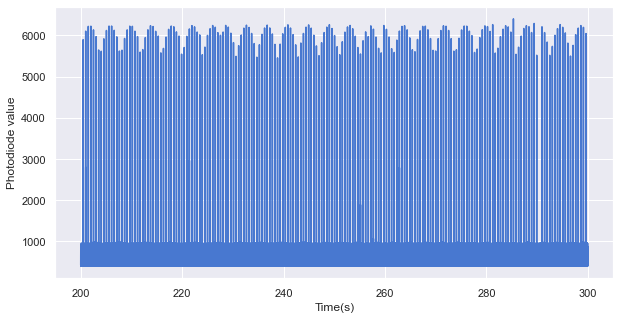

In [32]:
%matplotlib inline
palette = itertools.cycle(sns.color_palette(palette="muted"))
plt.figure(figsize=(10, 5))
sns.lineplot(
    x=recordings[8]["eeg"]["timestamps"][204800:307200],
    y=recordings[8]["eeg"]["color"][204800:307200],
    color=next(palette),
)
plt.ylabel("Photodiode value")
plt.xlabel("Time(s)")
plt.show()

Expected vs detected peaks

In [33]:
display(peaks_desc)

,maximum,u_color,% u_color,e_color,% e_color,u_audio,% u_audio,e_audio,% e_audio
bw1_sc,244,239,97.95082,237,99.16318,239,97.95082,239,100.00000
bw_sc_b1,250,244,97.60000,242,99.18033,244,97.60000,244,100.00000
bw_sc_b2,268,262,97.76119,258,98.47328,262,97.76119,262,100.00000
bw3_sc,273,268,98.16850,264,98.50746,268,98.16850,267,99.62687
bw2_sc,277,271,97.83394,268,98.89299,271,97.83394,271,100.00000
bw_sc_b3,290,286,98.62069,282,98.60140,286,98.62069,284,99.30070
bw_tc_r,879,860,97.83845,856,99.53488,860,97.83845,860,100.00000
wd_50hz_1,1247,1247,100.00000,1241,99.51885,1247,100.00000,1247,100.00000
wd_1,1248,1221,97.83654,1218,99.75430,1221,97.83654,1221,100.00000
wd_50hz_oc,2442,2442,100.00000,2442,100.00000,2442,100.00000,2,0.08190


#### __Descriptive Statistics__ 

###### __Diode__

In [34]:
display(c_stats.style.applymap(color_checks, subset=["AVG"]))

,bw1_sc,bw_sc_b1,bw_sc_b2,bw3_sc,bw2_sc,bw_sc_b3,bw_tc_r,wd_50hz_1,wd_1,wd_50hz_oc,wd_50hz_oc_sc,wd_50hz_oc_r,wd_50hz_2,bw_tc_L2,bw_tc_L3,bw_tc_L4,bw_tc_L1,AVG
count,237.000000,242.000000,258.000000,264.000000,268.000000,282.000000,856.000000,1241.000000,1218.000000,2442.000000,2938.000000,3118.000000,3248.000000,3520.000000,3604.000000,4172.000000,7706.000000,2094.941176
mean,0.075043,0.075053,0.075050,0.075026,0.075027,0.075070,0.085203,0.089304,0.083596,0.089424,0.087508,0.088070,0.089654,0.073522,0.073504,0.075977,0.075361,0.080082
std,0.000495,0.000348,0.000543,0.000507,0.000383,0.000660,0.000601,0.004913,0.000715,0.005011,0.005350,0.005403,0.005046,0.000365,0.000406,0.000406,0.000301,0.001850
min,0.073792,0.074127,0.073756,0.073762,0.072521,0.073900,0.084378,0.085072,0.081619,0.085345,0.082580,0.081890,0.084928,0.062520,0.062223,0.064602,0.074084,0.075947
25%,0.074742,0.074797,0.074765,0.074752,0.074783,0.074765,0.084939,0.086299,0.083269,0.086223,0.083531,0.083867,0.086395,0.073278,0.073266,0.075732,0.075118,0.078854
50%,0.075020,0.075041,0.075039,0.075005,0.075050,0.074964,0.085185,0.086549,0.083534,0.086491,0.083806,0.084475,0.086658,0.073521,0.073511,0.075978,0.075364,0.079129
75%,0.075293,0.075276,0.075288,0.075263,0.075274,0.075275,0.085423,0.097216,0.083796,0.097341,0.094731,0.094976,0.097507,0.073777,0.073758,0.076228,0.075610,0.082472
max,0.080321,0.076752,0.080420,0.079667,0.077808,0.080432,0.096419,0.098818,0.093438,0.098574,0.099556,0.098666,0.098488,0.075394,0.077715,0.081206,0.075989,0.086451


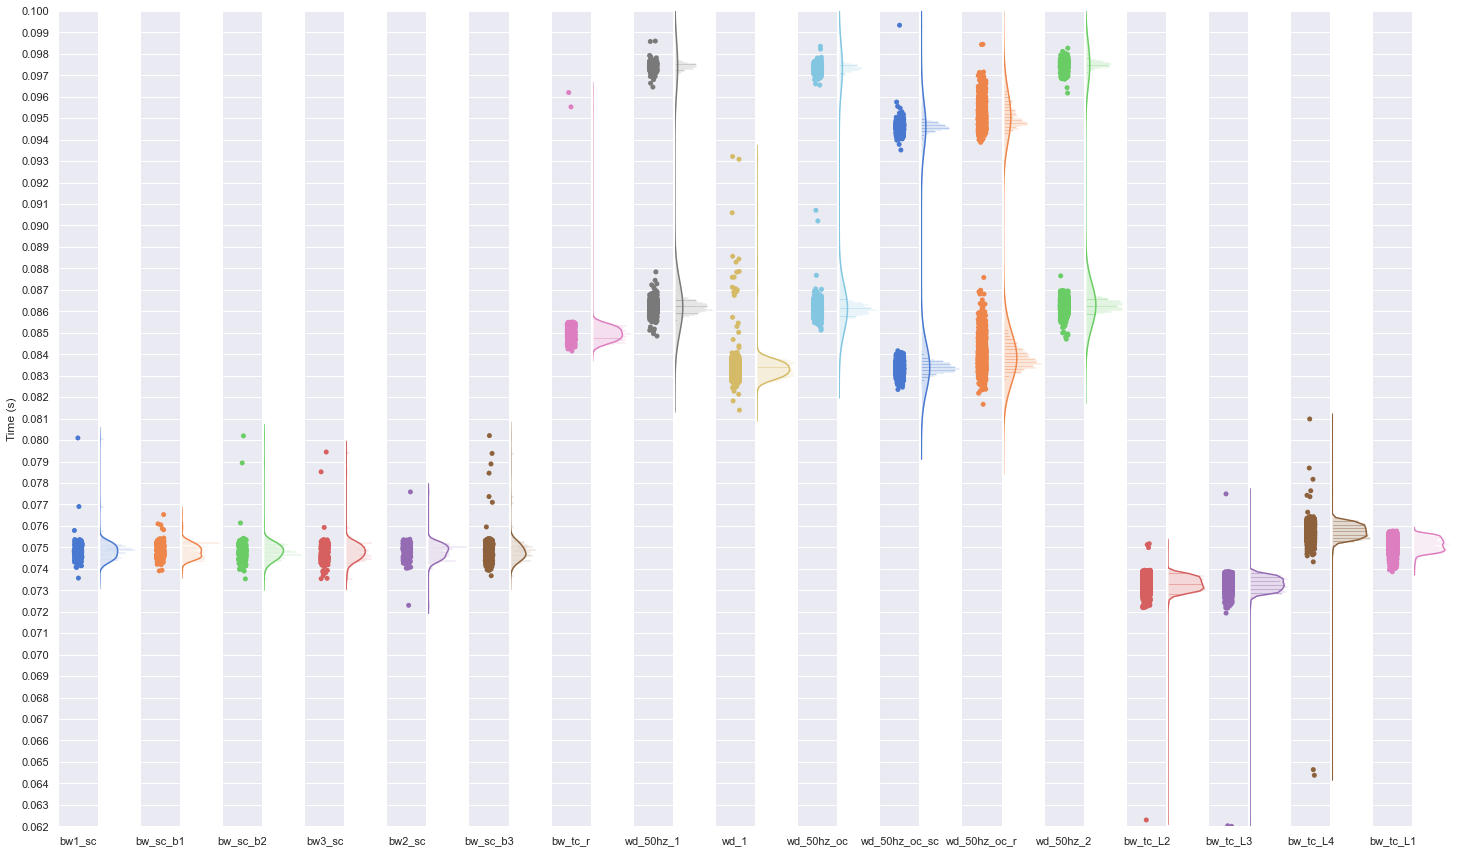

In [35]:
%matplotlib inline
nplots = len(c_diff_all) * 2  # number of subplots
palette = itertools.cycle(sns.color_palette(palette="muted"))

# define subplots
fig = plt.figure(figsize=(25, 15))
cols = 1
gs = fig.add_gridspec(cols, nplots)

y_max = 0
y_min = 1
# since sharey does not work in this context by adding subplots one by one
for dist in c_diff_all:  # get the maximum y value to set the same scale on subplots
    if max(dist) > y_max:
        y_max = max(dist)
    if min(dist) < y_min:
        y_min = min(dist)

step = 0.001
ticks = np.arange(y_min, y_max + step, step)
kde = {"shade": True}
j = 0
for i in range(nplots):
    style = "darkgrid" if i % 2 == 0 else "white"
    with sns.axes_style(style):
        ax = fig.add_subplot(gs[i])
        if i % 2 == 0:
            color = next(palette)
            sns.stripplot(x=c_diff_all[j], ax=ax, orient="v", color=color)
            ax.set_xticklabels([fnames[j]])  # filename
            ax.set_ylim(y_min, y_max)
            ax.set_yticks(ticks)
            ax.yaxis.set_major_formatter(FormatStrFormatter("%.3f"))
        else:
            sns.distplot(
                c_diff_all[j],
                ax=ax,
                vertical=True,
                norm_hist=True,
                bins=250,
                kde_kws=kde,
                color=color,
            )
            ax.set_ylim(y_min, y_max)
            ax.set_yticks(ticks)
            ax.set_xticklabels([])
            sns.despine(left=True, bottom=True)
            j += 1
        if i != 0:
            ax.set_yticklabels([])


plt.subplots_adjust(wspace=0.05)

fig.axes[0].set_ylabel("Time (s)")
plt.show()

###### __Speaker__

In [36]:
display(a_stats.style.applymap(color_checks, subset=["AVG"]))

,bw1_sc,bw_sc_b1,bw_sc_b2,bw3_sc,bw2_sc,bw_sc_b3,bw_tc_r,wd_50hz_1,wd_1,wd_50hz_oc,wd_50hz_oc_sc,wd_50hz_oc_r,wd_50hz_2,bw_tc_L2,bw_tc_L3,bw_tc_L4,bw_tc_L1,AVG
count,239.000000,244.000000,262.000000,267.000000,271.000000,284.000000,860.000000,1247.000000,1221.000000,2.000000,2938.000000,3117.000000,3248.000000,3532.000000,3621.000000,4195.000000,7745.000000,1958.411765
mean,0.144945,0.139820,0.138772,0.143700,0.145448,0.143370,0.151401,0.192655,0.188514,0.117614,0.194133,0.190817,0.194157,0.139008,0.143982,0.139353,0.141965,0.155862
std,0.004377,0.004409,0.004587,0.006956,0.005367,0.004463,0.005220,0.007581,0.006686,0.014682,0.006756,0.006809,0.007414,0.004401,0.004967,0.004341,0.005451,0.006145
min,0.124942,0.128778,0.127420,0.125329,0.126975,0.131950,0.140721,0.077505,0.174040,0.107232,0.178056,0.174677,0.050937,0.125599,0.126703,0.125724,0.125079,0.127745
25%,0.141982,0.136593,0.135626,0.139428,0.141689,0.140020,0.148477,0.187583,0.183177,0.112423,0.188808,0.185473,0.188813,0.135901,0.140924,0.136362,0.138424,0.151865
50%,0.145270,0.139689,0.138773,0.144235,0.145351,0.143312,0.151101,0.192623,0.188539,0.117614,0.194176,0.190751,0.194205,0.139070,0.144053,0.139267,0.141961,0.155882
75%,0.148013,0.142652,0.141839,0.147746,0.148775,0.147163,0.153899,0.198180,0.193835,0.122805,0.199452,0.196319,0.199627,0.142038,0.146848,0.142362,0.145504,0.159827
max,0.157813,0.152345,0.154999,0.171731,0.174338,0.155167,0.257581,0.207508,0.202565,0.127996,0.210576,0.206491,0.210913,0.157790,0.284434,0.156623,0.201841,0.187689


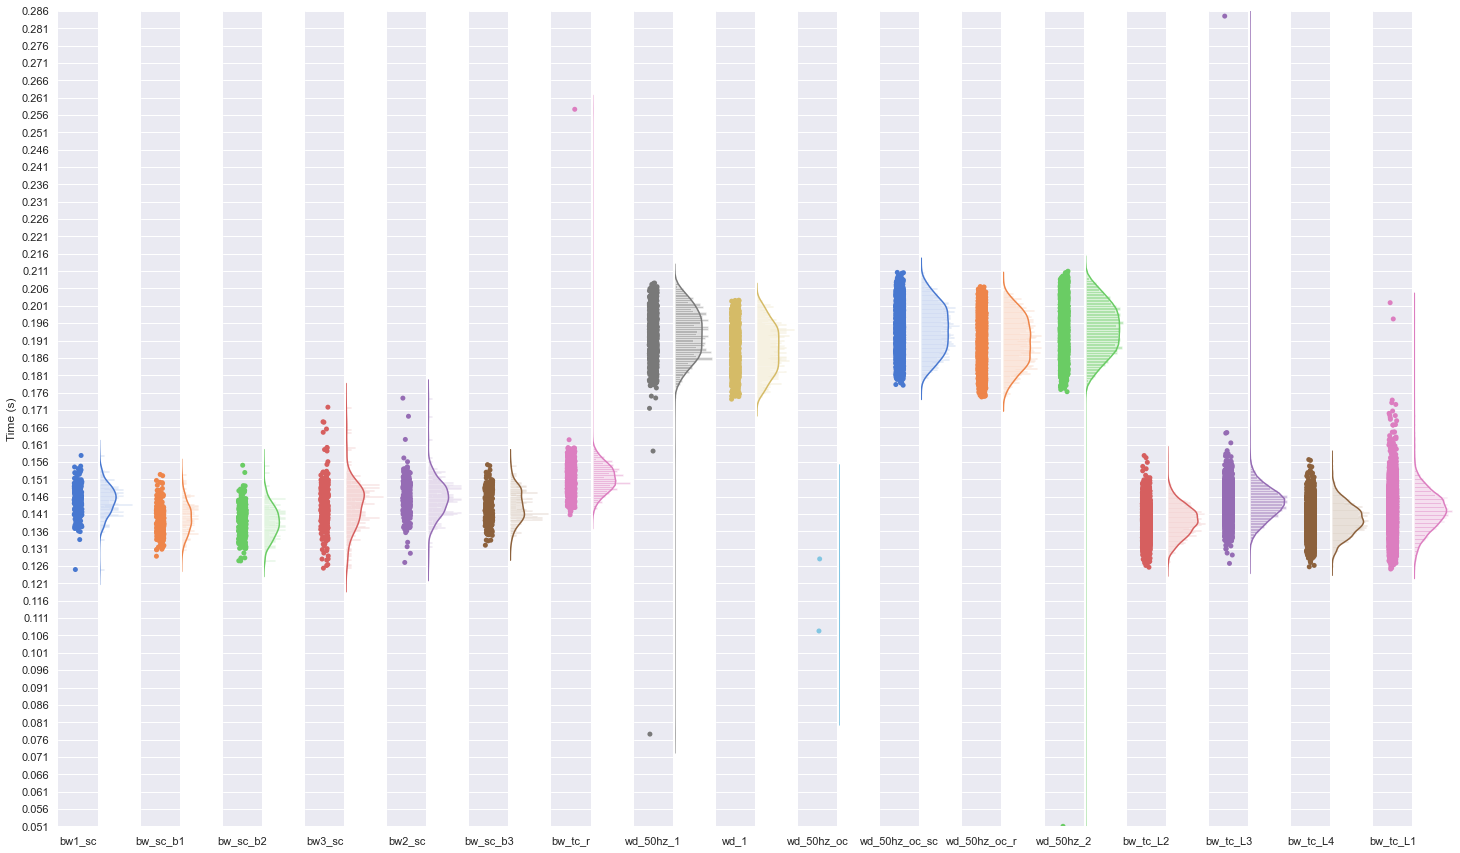

In [40]:
%matplotlib inline
nplots = len(c_diff_all) * 2  # number of subplots
palette = itertools.cycle(sns.color_palette(palette="muted"))

# define subplots
fig = plt.figure(figsize=(25, 15))
cols = 1
gs = fig.add_gridspec(cols, nplots)

y_max = 0
y_min = 1
# since sharey does not work in this context by adding subplots one by one
for dist in a_diff_all:  # get the maximum y value to set the same scale on subplots
    if max(dist) > y_max:
        y_max = max(dist)
    if min(dist) < y_min:
        y_min = min(dist)

step = 0.005
ticks = np.arange(y_min, y_max + step, step)
kde = {"shade": True}
j = 0
for i in range(nplots):
    style = "darkgrid" if i % 2 == 0 else "white"
    with sns.axes_style(style):
        ax = fig.add_subplot(gs[i])
        if i % 2 == 0:
            color = next(palette)
            sns.stripplot(x=a_diff_all[j], ax=ax, orient="v", color=color)
            ax.set_xticklabels([fnames[j]])  # filename
            ax.set_ylim(y_min, y_max)
            ax.set_yticks(ticks)
            ax.yaxis.set_major_formatter(FormatStrFormatter("%.3f"))
        else:
            sns.distplot(
                a_diff_all[j],
                ax=ax,
                vertical=True,
                norm_hist=True,
                bins=200,
                kde_kws=kde,
                color=color,
            )
            ax.set_ylim(y_min, y_max)
            ax.set_yticks(ticks)
            ax.set_xticklabels([])
            sns.despine(left=True, bottom=True)
            j += 1
        if i != 0:
            ax.set_yticklabels([])

plt.subplots_adjust(wspace=0.05)
fig.axes[0].set_ylabel("Time (s)")
plt.show()

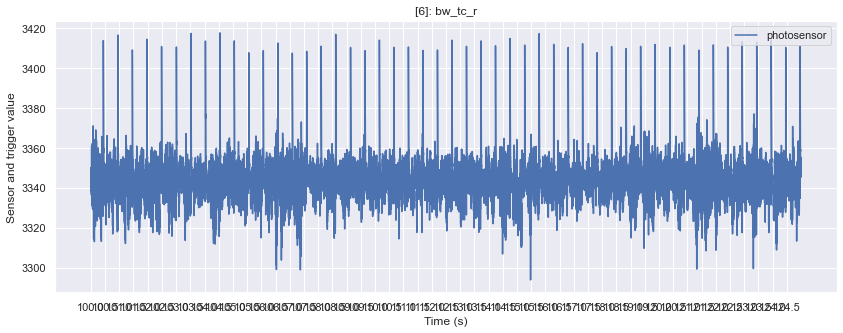

In [38]:
# interactive: widget, not interactive: inline
sns.set(rc={"figure.figsize": (14, 5)})  # set figure size
sns.set_style("darkgrid")  # set seaborn plotting style

f_n = 100  # -0.1  # starting point (s)
s_n = 125  # 1.2  # ending point (s)

start_e = 1024 * f_n  # eeg sampling rate = 1024
start_u = 90 * f_n  # unity sampling rate = 90

e_samples = 1024 * s_n  # N of eeg in 5 s
u_samples = 90 * s_n  # N of unity in 5 s
u_height = 3500  # factor to improve unity (true/1) values visualization

k = 6
if recordings[k]["lsl_aligned"]:
    file = recordings[k]["file"].split(".")[0]
    e = copy.deepcopy(recordings[k]["eeg"])
    u = copy.deepcopy(recordings[k]["unity"])
    e_t = e["timestamps"]
    u_t = u["timestamps"]
    e_a = e["audio"]
    e_c = e["color"]
    u_c = u["color"]
    u_a = u["audio"]
    # fix diff array sizes for unity color and audio arrays
    u_diff = len(u_c) - len(u_t)
    if u_diff > 0:
        print(f"{k}: {file} -> u_c is {u_diff} sample/s larger than u_t")
        # remove the diff from the end of the array
        u_c = u_c[:-u_diff]
    elif u_diff < 0:
        print(f"{k}: {file} -> u_c is {abs(u_diff)} sample/s smaller than u_t")
        # add the diff from the end of the array
        for i in range(abs(u_diff)):
            u_c = np.append(u_c, u_c[-1])

    # select range of timestamps, diode and microphone values (eeg)
    e_time_selection = e_t[(e_t > f_n) & (e_t < s_n)]
    e_color_selection = e_c[(e_t > f_n) & (e_t < s_n)]
    e_audio_selection = e_a[(e_t > f_n) & (e_t < s_n)]

    # select range of timestamps, color and audio values (unity)
    # u_time_selection = u_t[(u_t > f_n) & (u_t < s_n)]
    # u_color_selection = u_c[(u_t > f_n) & (u_t < s_n)]
    # u_audio_selection = u_a[(u_t > f_n) & (u_t < s_n)]

    # plot the selected range to compare eeg vs unity values
    # plt.plot(e_time_selection, e_color_selection * 0.05)
    plt.plot(e_time_selection, e_audio_selection * 1.5)
    # plt.plot(u_time_selection,u_color_selection * u_height,marker="o",markerfacecolor="None",)
    # plt.plot(u_time_selection, u_audio_selection * u_height, marker="x")

    plt.title(f"[{k}]: {file}")
    plt.ylabel("Sensor and trigger value")
    plt.xlabel("Time (s)")
    plt.xticks(np.arange(f_n, s_n, step=0.5))
    labels = ["photosensor", "microphone", "color", "audio"]
    plt.legend(labels, loc="upper right")  # set the legend
    plt.show()